        INTRODUCTION
    
    This notebook trains models that predicts the bid price of EURUSD 1 hours. 
    In the next sections, will be compared generalization ability of two models: gradient boosting LightGBM and recurrent neural network made of LSTM layers with keras/tensorflow.
    Will be used scikit-learn function GridSearchCV with TimeSeriesSplit cross-validation scheme for estimate the generalization ability. 

In [2]:
import sys; print('Python version: {}'.format(sys.version))
import os
    # Setting random seed for reproducability
sd = 1
import numpy as np; print('NumPy version: {}'.format(np.__version__))
np.random.seed(sd)
import random as rn
rn.seed(sd)
import tensorflow as tf; print('Tensorflow version: {}'.format(tf.version.VERSION))
tf.random.set_seed(sd)

import keras; print('Keras version: {}'.format(keras.__version__))
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import keras.backend as K

import pandas as pd; print('Pandas version: {}'.format(pd.__version__))
#import scipy as sp; print('SciPy version: {}'.format(sp.__version__))
import IPython; print('IPython version: {}'.format(IPython.__version__))

import sklearn; print('scikit-learn version: {}'.format(sklearn.__version__))
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing  import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
import lightgbm as lgb; print('lightGBM version: {}'.format(lgb.__version__))
import joblib

    # Visualisation
import matplotlib; print('Matplotlib version: {}'.format(matplotlib.__version__))
import matplotlib.pyplot as plt
import seaborn as sns; print('seaborn version: {}'.format(sns.__version__))

from time import time
from datetime import datetime
from datetime import date
from datetime import timedelta

from forex import *
import warnings

%env OMP_NUM_THREADS=8
%matplotlib inline

path = 'C:\\Users\\ALEX\\Documents\\PythonScripts\\1H-model-ver7.1-binary-1h-preds\\'
try: os.mkdir(path)
except FileExistsError: print('Directory alredy exist')

Python version: 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
NumPy version: 1.19.5
Tensorflow version: 2.4.1
Keras version: 2.4.3
Pandas version: 1.2.1
IPython version: 7.19.0
scikit-learn version: 0.22.1
lightGBM version: 3.1.1
Matplotlib version: 3.3.4
seaborn version: 0.11.1
env: OMP_NUM_THREADS=8
Directory alredy exist


In [3]:
name = 'EURUSDH1'
    # EUR/USD history was get from Roboforex broker (MetaTraider 5 script)
data = pd.read_csv('C:\\Users\\ALEX\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common\\Files\\History\\%s.csv' % name,
                   sep=',', names=["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOL"])
data.reset_index(drop=True, inplace=True)
data['HOUR']= [x.split(':')[0] for x in data.TIME]
data['DATE']= data['DATE'] + data['HOUR']
data['HOUR']= data['HOUR'].astype('int')
data.drop(['TIME'], axis=1, inplace=True)
data['DATE']=[datetime.strptime(x, '%Y.%m.%d%H') for x in data.DATE.astype(str)]
data

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,HOUR
0,2003-07-28 00:00:00,1.14970,1.15050,1.14950,1.14990,200,0
1,2003-07-28 01:00:00,1.15000,1.15050,1.14870,1.14910,283,1
2,2003-07-28 02:00:00,1.14940,1.14980,1.14820,1.14830,328,2
3,2003-07-28 03:00:00,1.14830,1.14900,1.14640,1.14770,428,3
4,2003-07-28 04:00:00,1.14740,1.14800,1.14650,1.14760,360,4
...,...,...,...,...,...,...,...
105788,2020-07-20 15:00:00,1.14453,1.14492,1.14149,1.14177,4586,15
105789,2020-07-20 16:00:00,1.14176,1.14285,1.14016,1.14182,6423,16
105790,2020-07-20 17:00:00,1.14178,1.14435,1.14103,1.14389,5674,17
105791,2020-07-20 18:00:00,1.14389,1.14477,1.14356,1.14423,3480,18


In [4]:
data.describe()

,OPEN,HIGH,LOW,CLOSE,VOL,HOUR
count,105793.000000,105793.000000,105793.000000,105793.000000,1.057930e+05,105793.000000
mean,1.260432,1.261486,1.259372,1.260433,1.525908e+05,11.499627
std,0.122639,0.122798,0.122466,0.122637,4.182847e+07,6.917781
min,1.035570,1.037010,1.034030,1.035600,0.000000e+00,0.000000
25%,1.142780,1.143680,1.141800,1.142770,1.581000e+03,6.000000
50%,1.263700,1.264900,1.262600,1.263800,5.130000e+03,12.000000
75%,1.347400,1.348600,1.346200,1.347400,1.632700e+04,17.000000
max,1.601400,1.603800,1.599200,1.601400,1.360507e+10,23.000000


In [5]:
    # Function from StackOverflow
def missing_values_table(df):
   df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Total missing values
   mis_val = df.isnull().sum()
    # Make a table with the results
   mis_val_table = pd.DataFrame({'Missing Values':mis_val, '% of Total Values':100*mis_val/len(df)})
    # Sort the table by percentage of missing descending
   mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    # Print some summary information
   print("Your selected dataframe has "+str(df.shape[1])+" columns and "+str(df.shape[0])+
       " rows.\n"+"There are "+str(mis_val_table.shape[0])+" columns that have missing values.")
    # Return the dataframe with missing information
   return mis_val_table

missing_values_table(data)

Your selected dataframe has 7 columns and 105793 rows.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


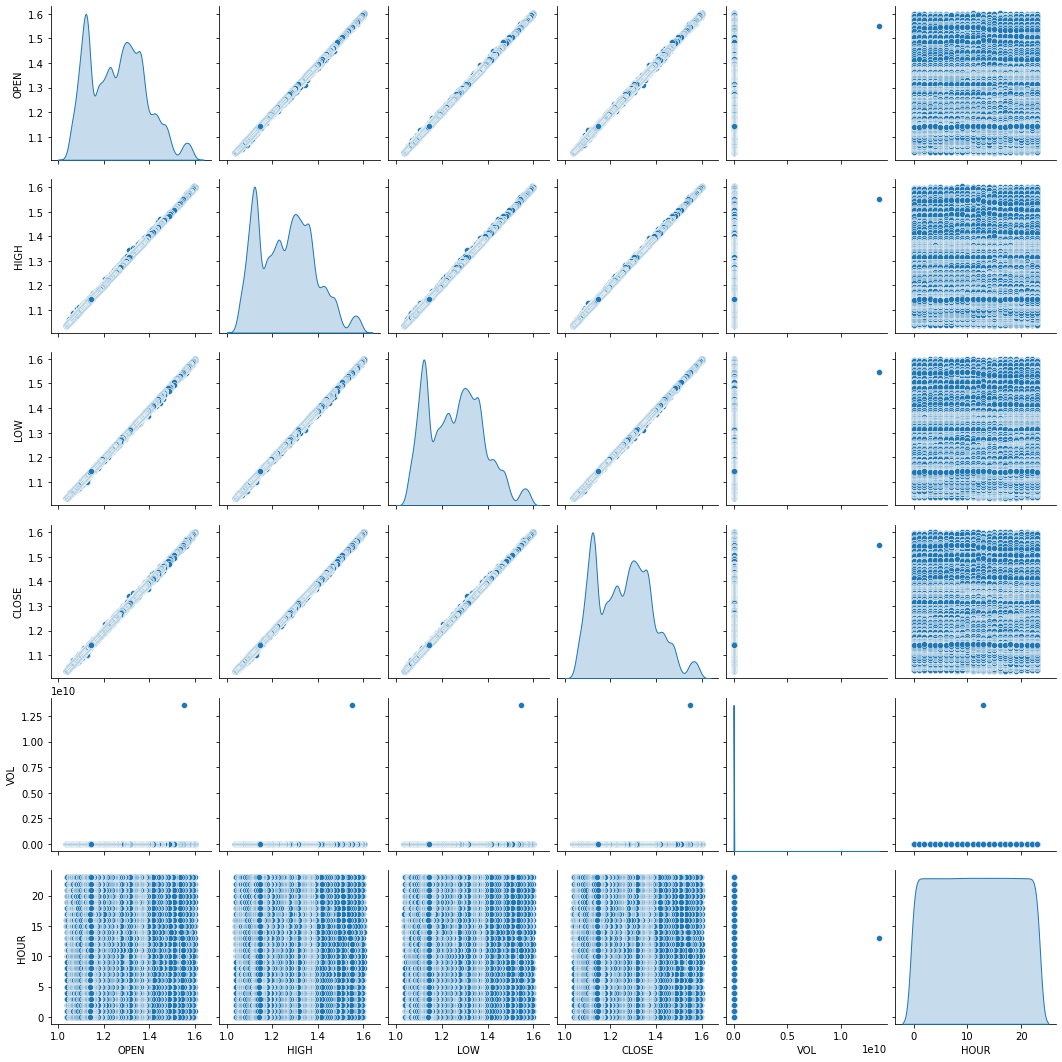

In [6]:
sns.pairplot(data, diag_kind="kde")

Some sort values of VOLUME =  [          0           1           2 ...      608263      749810
 13605071265]


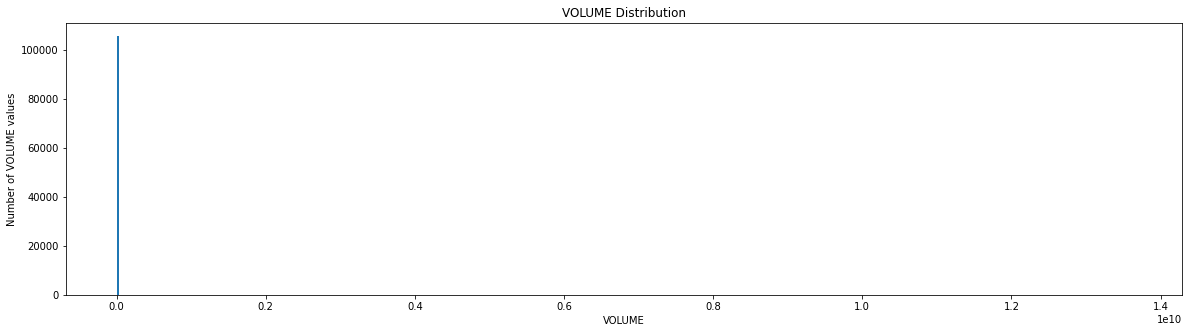

In [7]:
    # There is outlier in VOLUME feature
print("Some sort values of VOLUME = ",np.sort(data.VOL.unique()))

plt.figure(figsize=(20,5))
plt.hist(data.VOL,bins=500)
plt.xlabel('VOLUME'); plt.ylabel('Number of VOLUME values')
plt.title('VOLUME Distribution');

Some max values =  [526977 541083 544115 545516 557202 567045 572337 590926 608263 749810]


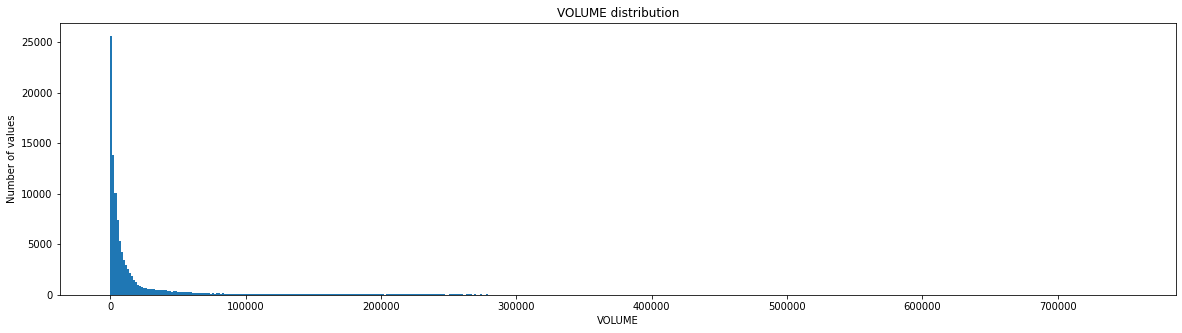

In [8]:
    # Replace max value of VOLUME by previous max value
previous_max = data.VOL[data.VOL != data.VOL.max()].max()
data.replace({'VOL': data.VOL.max()}, previous_max, inplace=True)
print('Some max values = ',np.sort(data.VOL.unique())[-10:])
plt.figure(figsize=(20,5))
plt.hist(data.VOL,bins=500)
plt.xlabel('VOLUME'); plt.ylabel('Number of values')
plt.title('VOLUME distribution');

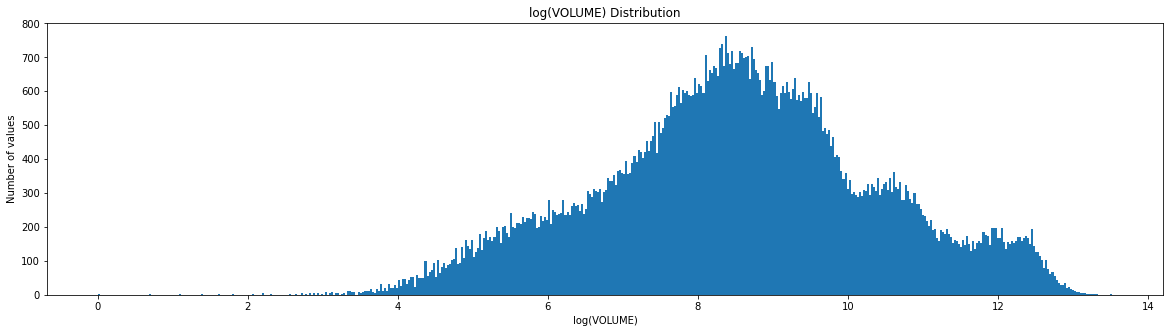

In [9]:
    # VOLUME has exponential dependence, use log operation
data['VOL']=data['VOL'].astype(float)
data.loc[data.VOL < 1,'VOL'] = 1
data['VOL_log'] = np.log(data.VOL)
plt.figure(figsize=(20,5))
plt.hist(data.VOL_log,bins=500)
plt.xlabel('log(VOLUME)'); plt.ylabel('Number of values')
plt.title('log(VOLUME) Distribution');

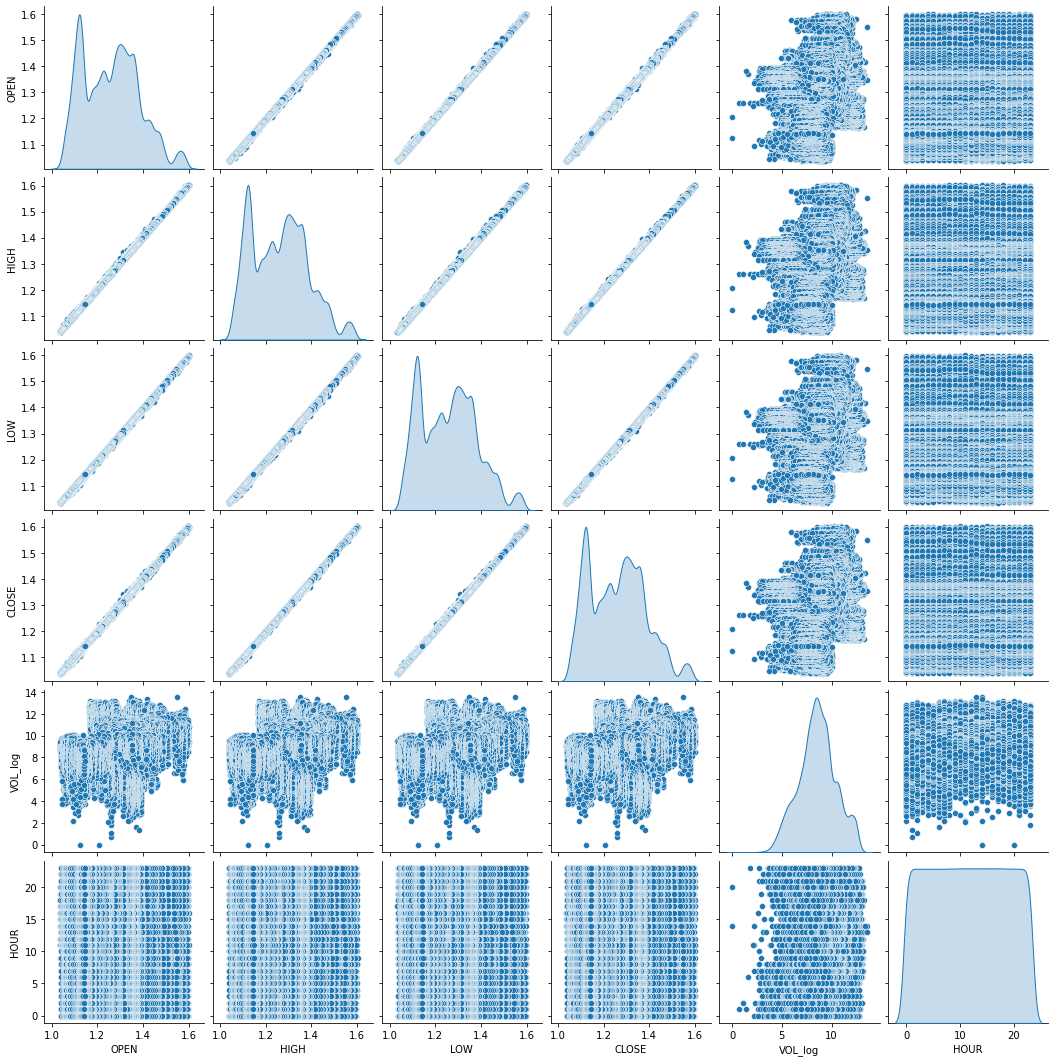

In [10]:
sns.pairplot(data[['OPEN', 'HIGH', 'LOW','CLOSE','VOL_log','HOUR']], diag_kind="kde")

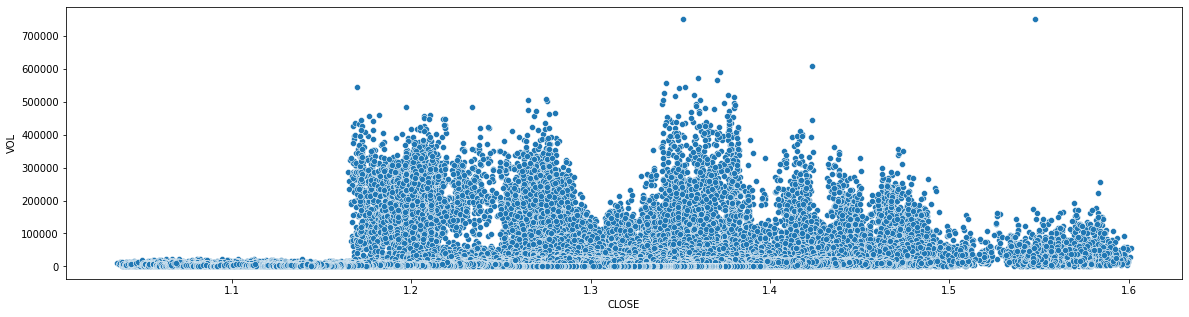

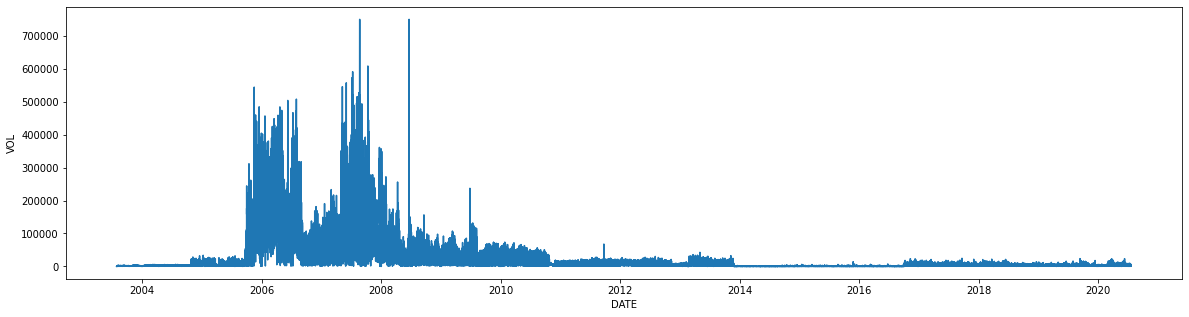

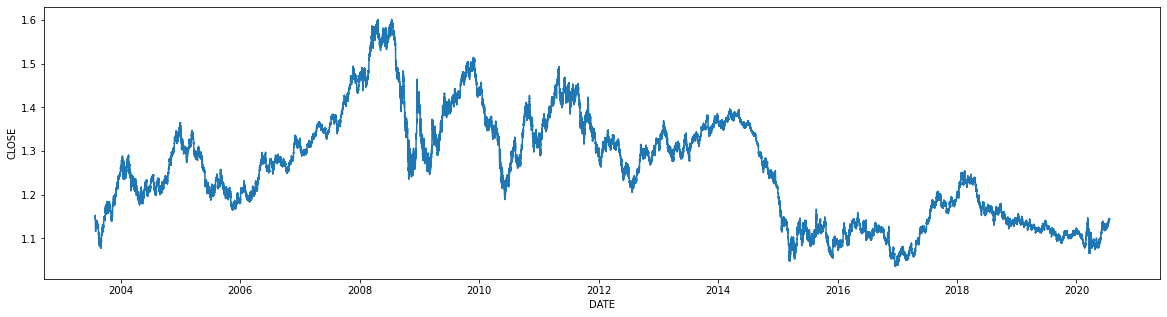

In [11]:
    # There is strange rectangular outcut of CLOSE/VOL relationship 
    # Let's look closer
with warnings.catch_warnings():
   warnings.filterwarnings('ignore')
   plt.figure(figsize=(20,5))
   sns.scatterplot(data.CLOSE,data.VOL)
   plt.figure(figsize=(20,5))
   sns.lineplot(data.DATE,data.VOL)
   plt.figure(figsize=(20,5))
   sns.lineplot(data.DATE,data.CLOSE)

# In the 2006-2009 years VOLUME incresed very much. 

# This situation can happen again in the future, then we should use this data. 

In [12]:
    # Build forex indicators as new features
    # Some forex indicators need to HIGH != LOW
data[data['HIGH'] == data['LOW']]

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,HOUR,VOL_log
2715,2004-01-01 01:00:00,1.2595,1.2595,1.2595,1.2595,2.0,1,0.693147
2716,2004-01-01 02:00:00,1.2595,1.2595,1.2595,1.2595,3.0,2,1.098612
82254,2016-10-02 20:00:00,1.1241,1.1241,1.1241,1.1241,1.0,20,0.000000


In [13]:
    # So change LOW values on minimum price action
data.loc[data['HIGH'] == data['LOW'],'LOW'] -= 1e-5
data[data['HIGH'] == data['LOW']]

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,HOUR,VOL_log


In [14]:
def extract_features(data):
    data['YEAR']= [x.year for x in data.DATE]
    data['YEAR']=data['YEAR'].astype(int)
    data['MONTH']= [x.month for x in data.DATE]
    data['MONTH']=data['MONTH'].astype(int)
    data['YEARWEEK']= [x.isocalendar()[1] for x in data.DATE]
    data['YEARWEEK']=data['YEARWEEK'].astype(int)
    data['MONTHDAY']= [x.day for x in data.DATE]
    data['MONTHDAY']=data['MONTHDAY'].astype(int)
    data['WEEKDAY']= [x.weekday() for x in data.DATE]
    data['WEEKDAY']=data['WEEKDAY'].astype(int)
    data['YEARDAY']= [x.strftime('%j') for x in data.DATE]
    data['YEARDAY']=data['YEARDAY'].astype(int)

        # YEARDAY values differ for leap and nonleap years
        # For leap year:    01 march is 61 yearday
        # For nonleap year: 01 march is 60 yearday
    for i in range(data.shape[0]):
            # if leap year, then continue 
        if np.mod(data.YEAR.iloc[i], 4) == 0:
            continue
        elif data.YEARDAY.iloc[i] >= 60:
            data.loc[i,'YEARDAY'] += 1
        # YEAR as feature is meaningless
    data.drop(['YEAR'], axis=1, inplace=True)
        # At the weekends price movement is very low, so drop it 
    data = data[data.WEEKDAY <= 4]
    data.reset_index(drop=True, inplace=True)

    data['O/C']=data['OPEN']/data['CLOSE'].astype(int)
    data['H/L']=data['HIGH']/data['LOW']
    data['L-C']=data['LOW']-data['CLOSE']
    data['deltaL-C'] = data['L-C'].diff(periods=1)
    data['H-L']=data['HIGH']-data['LOW']
    data['O-C']=data['OPEN']-data['CLOSE']
    data['H-O']=data['HIGH']-data['OPEN']
    data['H-C']=data['HIGH']-data['CLOSE']
    data['L-O']=data['LOW']-data['OPEN']
    data['deltaVOL'] = data.VOL.diff(periods=1)
    data['deltaCLOSE'] = data.CLOSE.diff(periods=1)
    
    period = 14
    s = 'CLOSE'
    data = moving_average(data, s, period)
    for p in [25,55]:
        data = exponential_moving_average(data, s, p)
    data = momentum(data, s, period)
    data = rate_of_change(data, s, period)
    data = average_true_range(data, period)
    data['ATR_'+str(period)+'_d'] = data['ATR_'+str(period)]/data['ATR_'+str(period)].shift(1)
    data = stochastic_oscillator_k(data)
    data = stochastic_oscillator_d(data, period)
    data['SO%d_'+str(period)+'_d'] = data['SO%d_'+str(period)]/data['SO%d_'+str(period)].shift(1)
    data = trix(data, s, period)
    data['Trix_'+str(period)+s+'_d'] = data['Trix_'+str(period)+s]/data['Trix_'+str(period)+s].shift(1)
    data = average_directional_movement_index(data, period, period)
    data['ADX_'+str(period)+'_'+str(period)+'_d'] = data['ADX_'+str(period)+'_'+str(period)]/data['ADX_'+str(period)+'_'+str(period)].shift(1)
    data = macd(data, s, period, 2*period)
    data = mass_index(data, period)
    data = vortex_indicator(data, period)
    data = kst_oscillator(data, s, int(period/2),period-1,period,2*period-2,int(period/2),int(period/2),int(period/2),period-1)
    data['KST_'+str(int(period/2))+'_'+str(period-1)+'_'+str(period)+'_'+str(2*period-2)+'_'+str(int(period/2))+'_'+str(int(period/2))+'_'+str(int(period/2))+'_'+str(period-1)+s+'_d'] = data['KST_'+str(int(period/2))+'_'+str(period-1)+'_'+str(period)+'_'+str(2*period-2)+'_'+str(int(period/2))+'_'+str(int(period/2))+'_'+str(int(period/2))+'_'+str(period-1)+s]/data['KST_'+str(int(period/2))+'_'+str(period-1)+'_'+str(period)+'_'+str(2*period-2)+'_'+str(int(period/2))+'_'+str(int(period/2))+'_'+str(int(period/2))+'_'+str(period-1)+s].shift(1)
    data = relative_strength_index(data, period)
    data['RSI_'+str(period)+'_d'] = data['RSI_'+str(period)]/data['RSI_'+str(period)].shift(1)
    data = true_strength_index(data, s, 2*period-2, period)
    data['TSI_'+str(2*period-2)+'_'+str(period)+s+'_d'] = data['TSI_'+str(2*period-2)+'_'+str(period)+s]/data['TSI_'+str(2*period-2)+'_'+str(period)+s].shift(1)
    data = commodity_channel_index(data, period)
    data['CCI_'+str(period)+'_d'] = data['CCI_'+str(period)].diff(1)
    data = coppock_curve(data, s, period)
    data = keltner_channel(data, period)
    data['KelChM_'+str(period)+'_d'] = data['KelChM_'+str(period)]/data['KelChM_'+str(period)].shift(1)
    data['KelChU_'+str(period)+'_d'] = data['KelChU_'+str(period)]/data['KelChU_'+str(period)].shift(1)
    data['KelChD_'+str(period)+'_d'] = data['KelChD_'+str(period)]/data['KelChD_'+str(period)].shift(1)
    data = ultimate_oscillator(data)
    data['Ultimate_Osc_d'] = data['Ultimate_Osc']/data['Ultimate_Osc'].shift(1)
    data = donchian_channel(data, 2*period)
    data['Donchian_'+str(2*period)+'_d'] = data['Donchian_'+str(2*period)]/data['Donchian_'+str(2*period)].shift(1)
    data = standard_deviation(data, s, period)
    #data['STD_'+str(period)+s+'_d'] = data['STD_'+str(period)+s]/data['STD_'+str(period)+s].shift(1)
    data = bollinger_bands(data, s, period)
    data['BollingerB_'+str(period)+s+'_d'] = data['BollingerB_'+str(period)+s]/data['BollingerB_'+str(period)+s].shift(1)
    data['Bollinger%b_'+str(period)+s+'_d'] = data['Bollinger%b_'+str(period)+s]/data['Bollinger%b_'+str(period)+s].shift(1)
    data = accumulation_distribution(data, period)
    data = chaikin_oscillator(data)
    data['Chaikin_d'] = data['Chaikin']/data['Chaikin'].shift(1)
    data = money_fLOW_index(data, period)
    data = on_balance_VOL(data, period)
    data = force_index(data, period)
    data = ease_of_movement(data, period)
    data = ppsr(data)
    data.drop(range(0,5*period), axis=0, inplace=True)
    data.reset_index(drop=True, inplace=True)

        # Features created below are from forex trading tips
        # "Narrow range bar" of previous 7 bars
    data['nr_bin']=data['H-L'].rolling(7).min() == data['H-L']
        # "Pullback" of price
    data['ma_buy'] = (data.CLOSE < data.EMA_25CLOSE) & (data.CLOSE > data.EMA_55CLOSE)
    data['ma_sell'] = (data.CLOSE > data.EMA_25CLOSE) & (data.CLOSE < data.EMA_55CLOSE)
        # "Breakout/Breakdown" when VOLUME increase. Threshold get empirically by previous analysis.
    data['deltavol_bin'] = data.deltaVOL > 550
    data['sell'] = data.deltaCLOSE < 0
    data['buy'] = data.deltaCLOSE >= 0
    return data

In [15]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    data = extract_features(data)

missing_values_table(data)

Your selected dataframe has 87 columns and 104448 rows.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [17]:
data['y'] = data.CLOSE.diff(1) > 0
data

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,HOUR,VOL_log,MONTH,YEARWEEK,...,S2,R3,S3,nr_bin,ma_buy,ma_sell,deltavol_bin,sell,buy,y
0,2003-07-30 22:00:00,1.13420,1.13490,1.13390,1.13440,393.0,22,5.973810,7,31,...,1.133400,1.135900,1.132900,False,False,False,False,False,True,False
1,2003-07-30 23:00:00,1.13430,1.13750,1.13420,1.13580,451.0,23,6.111467,7,31,...,1.132533,1.140767,1.130867,False,False,False,False,False,True,True
2,2003-07-31 00:00:00,1.13570,1.13630,1.13430,1.13510,410.0,0,6.016157,7,31,...,1.133233,1.138167,1.132167,False,False,False,False,True,False,False
3,2003-07-31 01:00:00,1.13510,1.13600,1.13400,1.13460,409.0,1,6.013715,7,31,...,1.132867,1.137733,1.131733,False,False,False,False,True,False,False
4,2003-07-31 02:00:00,1.13460,1.13630,1.13420,1.13570,431.0,2,6.066108,7,31,...,1.133300,1.138700,1.132400,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104443,2020-07-20 15:00:00,1.14453,1.14492,1.14149,1.14177,4586.0,15,8.430763,7,30,...,1.139297,1.147393,1.137103,False,False,False,False,True,False,False
104444,2020-07-20 16:00:00,1.14176,1.14285,1.14016,1.14182,6423.0,16,8.767641,7,30,...,1.138920,1.145750,1.137680,False,False,False,True,False,True,True
104445,2020-07-20 17:00:00,1.14178,1.14435,1.14103,1.14389,5674.0,17,8.643650,7,30,...,1.139770,1.148470,1.138510,False,False,False,False,False,True,True
104446,2020-07-20 18:00:00,1.14389,1.14477,1.14356,1.14423,3480.0,18,8.154788,7,30,...,1.142977,1.146023,1.142393,False,False,False,False,False,True,True


In [15]:
    # Target is 1 hour binary predictions of CLOSE price
    # If price go high, then target class = 1
data['y'] = data.CLOSE.diff(1).shift(-1) > 0
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,HOUR,VOL_log,MONTH,YEARWEEK,...,S2,R3,S3,nr_bin,ma_buy,ma_sell,deltavol_bin,sell,buy,y
0,2003-07-30 22:00:00,1.13420,1.13490,1.13390,1.13440,393.0,22,5.973810,7,31,...,1.133400,1.135900,1.132900,False,False,False,False,False,True,True
1,2003-07-30 23:00:00,1.13430,1.13750,1.13420,1.13580,451.0,23,6.111467,7,31,...,1.132533,1.140767,1.130867,False,False,False,False,False,True,False
2,2003-07-31 00:00:00,1.13570,1.13630,1.13430,1.13510,410.0,0,6.016157,7,31,...,1.133233,1.138167,1.132167,False,False,False,False,True,False,False
3,2003-07-31 01:00:00,1.13510,1.13600,1.13400,1.13460,409.0,1,6.013715,7,31,...,1.132867,1.137733,1.131733,False,False,False,False,True,False,True
4,2003-07-31 02:00:00,1.13460,1.13630,1.13420,1.13570,431.0,2,6.066108,7,31,...,1.133300,1.138700,1.132400,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104443,2020-07-20 15:00:00,1.14453,1.14492,1.14149,1.14177,4586.0,15,8.430763,7,30,...,1.139297,1.147393,1.137103,False,False,False,False,True,False,True
104444,2020-07-20 16:00:00,1.14176,1.14285,1.14016,1.14182,6423.0,16,8.767641,7,30,...,1.138920,1.145750,1.137680,False,False,False,True,False,True,True
104445,2020-07-20 17:00:00,1.14178,1.14435,1.14103,1.14389,5674.0,17,8.643650,7,30,...,1.139770,1.148470,1.138510,False,False,False,False,False,True,True
104446,2020-07-20 18:00:00,1.14389,1.14477,1.14356,1.14423,3480.0,18,8.154788,7,30,...,1.142977,1.146023,1.142393,False,False,False,False,False,True,False


In [16]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',500)
data.describe(include='all')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """


,DATE,OPEN,HIGH,LOW,CLOSE,VOL,HOUR,VOL_log,MONTH,YEARWEEK,MONTHDAY,WEEKDAY,YEARDAY,O/C,H/L,L-C,deltaL-C,H-L,O-C,H-O,H-C,L-O,deltaVOL,deltaCLOSE,MA_14CLOSE,EMA_25CLOSE,EMA_55CLOSE,Momentum_14CLOSE,ROC_14CLOSE,ATR_14,ATR_14_d,SO%k,SO%d_14,SO%d_14_d,Trix_14CLOSE,Trix_14CLOSE_d,ADX_14_14,ADX_14_14_d,MACD_14_28CLOSE,MACDsign_14_28CLOSE,MACDdiff_14_28CLOSE,Mass Index14,Vortex_14,KST_7_13_14_26_7_7_7_13CLOSE,KST_7_13_14_26_7_7_7_13CLOSE_d,RSI_14,RSI_14_d,TSI_26_14CLOSE,TSI_26_14CLOSE_d,CCI_14,CCI_14_d,Copp_14CLOSE,KelChM_14,KelChU_14,KelChD_14,KelChM_14_d,KelChU_14_d,KelChD_14_d,Ultimate_Osc,Ultimate_Osc_d,Donchian_28,Donchian_28_d,STD_14CLOSE,BollingerB_14CLOSE,Bollinger%b_14CLOSE,BollingerB_14CLOSE_d,Bollinger%b_14CLOSE_d,Acc/Dist_ROC_14,Chaikin,Chaikin_d,MFI_14,OBV_14,Force_14,EoM_14,PP,R1,S1,R2,S2,R3,S3,nr_bin,ma_buy,ma_sell,deltavol_bin,sell,buy,y
count,104448,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,1.044480e+05,104448.000000,1.044480e+05,104448.000000,104448.000000,104448.000000,104448.000000,1.044480e+05,104448.000000,104448.000000,104448.000000,1.044480e+05,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,1.044480e+05,104448.000000,104448.000000,104448.000000,1.044480e+05,1.044480e+05,1.044480e+05,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,1.044480e+05,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,1.044480e+05,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448.000000,104448,104448,104448,104448,104448,104448,104448
unique,104448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2
top,2013-06-07 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84686,97737,97753,72697,54427,54427,53853
first,2003-07-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-07-20 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.259713,1.260765,1.258654,1.259713,24143.397710,11.369974,8.541444,6.516563,26.563390,15.717678,1.975940,183.54

In [19]:
    # Learn LightGBM model using grid search with cross-validation
    # Gradient Boosting Decision Trees don't need to scaling
    # 6400 hours ~ 1 year
test_size = 6400
x_train = data[:-test_size].drop(['DATE','y'], axis=1)
y_train = data[:-test_size].y
x_test = data[-test_size:].drop(['DATE','y'], axis=1)
y_test = data[-test_size:].y

In [18]:
param_grid= {'boosting_type':    ['gbdt'],
             'num_leaves':       [3, 5, 7],
             'max_depth':        [2, 4, 6],
             'learning_rate':    [0.05, 0.1, 0.2],
             'min_child_samples':[10, 15, 20],
             'max_bin'          :[20, 100, 200],
             'reg_alpha':        [0.05, 0.1, 0.2],
             'reg_lambda':       [0.7, 0.8, 0.9]}
grid_search = GridSearchCV(lgb.LGBMClassifier(objective='binary', n_estimators=1000, metric= ['auc'],
                                              early_stopping_rounds = 100, n_jobs=-1, random_state=sd, silent=True),
                           param_grid,cv=TimeSeriesSplit(n_splits=7),scoring='roc_auc',n_jobs=-1)
now=datetime.now()
current_time=now.strftime("%d/%m/%y %H:%M:%S")
print('LightGBM start time = ',current_time)
start = time()
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  grid_result_gbm = grid_search.fit(x_train, y_train, eval_set=(x_test, y_test))
print('Passed %.1f hours'%((time() - start)/3600))
print('CV best AUC: %.4f,\nTest AUC: %.4f'%(grid_result_gbm.best_score_,grid_result_gbm.score(x_test,y_test)))
print('Best params: ', grid_result_gbm.best_params_)

LightGBM start time =  25/03/21 19:45:22
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's auc: 0.531224
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.53049
[3]	valid_0's auc: 0.53165
[4]	valid_0's auc: 0.531807
[5]	valid_0's auc: 0.531853
[6]	valid_0's auc: 0.531847
[7]	valid_0's auc: 0.531406
[8]	valid_0's auc: 0.531004
[9]	valid_0's auc: 0.531664
[10]	valid_0's auc: 0.531298
[11]	valid_0's auc: 0.532081
[12]	valid_0's auc: 0.532313
[13]	valid_0's auc: 0.532672
[14]	valid_0's auc: 0.532405
[15]	valid_0's auc: 0.53255
[16]	valid_0's auc: 0.533203
[17]	valid_0's auc: 0.532871
[18]	valid_0's auc: 0.532884
[19]	valid_0's auc: 0.532793
[20]	valid_0's auc: 0.532958
[21]	valid_0's auc: 0.533642
[22]	valid_0's auc: 0.533772
[23]	valid_0's auc: 0.53379
[24]	valid_0's auc: 0.533953
[25]	valid_0's auc: 0.533909
[26]	valid_0's auc: 0.534297
[27]	valid_0's auc:

[276]	valid_0's auc: 0.548346
[277]	valid_0's auc: 0.548219
[278]	valid_0's auc: 0.548241
[279]	valid_0's auc: 0.548156
[280]	valid_0's auc: 0.548099
[281]	valid_0's auc: 0.548124
[282]	valid_0's auc: 0.548091
[283]	valid_0's auc: 0.548153
[284]	valid_0's auc: 0.548153
[285]	valid_0's auc: 0.548208
[286]	valid_0's auc: 0.548129
[287]	valid_0's auc: 0.548217
[288]	valid_0's auc: 0.548216
[289]	valid_0's auc: 0.548279
[290]	valid_0's auc: 0.54825
[291]	valid_0's auc: 0.548307
[292]	valid_0's auc: 0.548434
[293]	valid_0's auc: 0.54842
[294]	valid_0's auc: 0.548402
[295]	valid_0's auc: 0.548489
[296]	valid_0's auc: 0.548471
[297]	valid_0's auc: 0.548452
[298]	valid_0's auc: 0.548509
[299]	valid_0's auc: 0.548822
[300]	valid_0's auc: 0.548806
[301]	valid_0's auc: 0.548782
[302]	valid_0's auc: 0.548776
[303]	valid_0's auc: 0.548826
[304]	valid_0's auc: 0.548802
[305]	valid_0's auc: 0.548874
[306]	valid_0's auc: 0.549015
[307]	valid_0's auc: 0.548978
[308]	valid_0's auc: 0.549138
[309]	valid_

In [19]:
    # Repeat GridSearchCV for more accurate parameters tuning
param_grid= {'boosting_type':    ['gbdt'],
             'num_leaves':       [7, 9, 11],
             'max_depth':        [6, 8, 10],
             'learning_rate':    [0.001, 0.005, 0.01, 0.05],
             'min_child_samples':[5, 7, 10],
             'max_bin'          :[5, 10, 15, 20],
             'reg_alpha':        [0.0, 0.01, 0.05],
             'reg_lambda':       [0.75, 0.8, 0.85]}
grid_search = GridSearchCV(lgb.LGBMClassifier(objective='binary', n_estimators=1000, metric= ['auc'],
                                              early_stopping_rounds = 100, n_jobs=-1, random_state=sd, silent=True),
                           param_grid,cv=TimeSeriesSplit(n_splits=7),scoring='roc_auc',n_jobs=-1)
now=datetime.now()
current_time=now.strftime("%d/%m/%y %H:%M:%S")
print('LightGBM start time with new_param_grid = ',current_time)
start = time()
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  grid_result_gbm = grid_search.fit(x_train, y_train, eval_set=(x_test, y_test))
print('Passed %.1f hours'%((time() - start)/3600))
print('CV best AUC: %.4f,\nTest AUC: %.4f'%(grid_result_gbm.best_score_,grid_result_gbm.score(x_test,y_test)))
print('Best params: ', grid_result_gbm.best_params_) 

LightGBM start time with new_param_grid =  25/03/21 22:47:00
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's auc: 0.531224
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.53049
[3]	valid_0's auc: 0.53165
[4]	valid_0's auc: 0.531807
[5]	valid_0's auc: 0.531853
[6]	valid_0's auc: 0.531847
[7]	valid_0's auc: 0.531406
[8]	valid_0's auc: 0.531004
[9]	valid_0's auc: 0.531664
[10]	valid_0's auc: 0.531298
[11]	valid_0's auc: 0.532081
[12]	valid_0's auc: 0.532313
[13]	valid_0's auc: 0.532672
[14]	valid_0's auc: 0.532405
[15]	valid_0's auc: 0.53255
[16]	valid_0's auc: 0.533203
[17]	valid_0's auc: 0.532871
[18]	valid_0's auc: 0.532884
[19]	valid_0's auc: 0.532793
[20]	valid_0's auc: 0.532958
[21]	valid_0's auc: 0.533642
[22]	valid_0's auc: 0.533772
[23]	valid_0's auc: 0.53379
[24]	valid_0's auc: 0.533953
[25]	valid_0's auc: 0.533909
[26]	valid_0's auc: 0.534297

[290]	valid_0's auc: 0.54825
[291]	valid_0's auc: 0.548307
[292]	valid_0's auc: 0.548434
[293]	valid_0's auc: 0.54842
[294]	valid_0's auc: 0.548402
[295]	valid_0's auc: 0.548489
[296]	valid_0's auc: 0.548471
[297]	valid_0's auc: 0.548452
[298]	valid_0's auc: 0.548509
[299]	valid_0's auc: 0.548822
[300]	valid_0's auc: 0.548806
[301]	valid_0's auc: 0.548782
[302]	valid_0's auc: 0.548776
[303]	valid_0's auc: 0.548826
[304]	valid_0's auc: 0.548802
[305]	valid_0's auc: 0.548874
[306]	valid_0's auc: 0.549015
[307]	valid_0's auc: 0.548978
[308]	valid_0's auc: 0.549138
[309]	valid_0's auc: 0.549164
[310]	valid_0's auc: 0.549109
[311]	valid_0's auc: 0.549109
[312]	valid_0's auc: 0.549053
[313]	valid_0's auc: 0.549055
[314]	valid_0's auc: 0.549056
[315]	valid_0's auc: 0.549099
[316]	valid_0's auc: 0.549202
[317]	valid_0's auc: 0.549103
[318]	valid_0's auc: 0.54901
[319]	valid_0's auc: 0.549191
[320]	valid_0's auc: 0.549193
[321]	valid_0's auc: 0.549126
[322]	valid_0's auc: 0.549063
[323]	valid_0

In [20]:
# LightGBM native training with best params and more epochs
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# specify configurations as a dict
params = grid_result_gbm.best_params_
params['metric'] = 'auc'
params['n_estimators'] = 4000
params['n_jobs'] = -1
params['verbose']  = 1
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params, lgb_train, valid_sets=[lgb_eval, lgb_train], early_stopping_rounds=300, evals_result=evals_result)
gbm.save_model(path+'lightgbm.txt')
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
print('Test data AUC score = %.4f' % roc_auc_score(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 98048, number of used features: 86
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.483273
[1]	training's auc: 0.544499	valid_0's auc: 0.531224
Training until validation scores don't improve for 300 rounds
[2]	training's auc: 0.544927	valid_0's auc: 0.53049
[3]	training's auc: 0.54632	valid_0's auc: 0.53165
[4]	training's auc: 0.547563	valid_0's auc: 0.531807
[5]	training's auc: 0.547605	valid_0's auc: 0.531853
[6]	training's auc: 0.547603	valid_0's auc: 0.531847
[7]	training's auc: 0.548753	valid_0's auc: 0.531406
[8]	training's auc: 0.550786	valid_0's auc: 0.531004
[9]	training

[146]	training's auc: 0.57662	valid_0's auc: 0.543902
[147]	training's auc: 0.576761	valid_0's auc: 0.543898
[148]	training's auc: 0.576914	valid_0's auc: 0.543867
[149]	training's auc: 0.577057	valid_0's auc: 0.543721
[150]	training's auc: 0.577201	valid_0's auc: 0.543737
[151]	training's auc: 0.577248	valid_0's auc: 0.543781
[152]	training's auc: 0.577415	valid_0's auc: 0.543683
[153]	training's auc: 0.577617	valid_0's auc: 0.544235
[154]	training's auc: 0.577741	valid_0's auc: 0.544243
[155]	training's auc: 0.577883	valid_0's auc: 0.544235
[156]	training's auc: 0.578034	valid_0's auc: 0.5442
[157]	training's auc: 0.578173	valid_0's auc: 0.544156
[158]	training's auc: 0.578219	valid_0's auc: 0.544109
[159]	training's auc: 0.578424	valid_0's auc: 0.544174
[160]	training's auc: 0.578523	valid_0's auc: 0.544175
[161]	training's auc: 0.578638	valid_0's auc: 0.544282
[162]	training's auc: 0.57879	valid_0's auc: 0.544625
[163]	training's auc: 0.578942	valid_0's auc: 0.54462
[164]	training'

[309]	training's auc: 0.597471	valid_0's auc: 0.547092
[310]	training's auc: 0.597594	valid_0's auc: 0.547177
[311]	training's auc: 0.597713	valid_0's auc: 0.547311
[312]	training's auc: 0.597827	valid_0's auc: 0.547343
[313]	training's auc: 0.598009	valid_0's auc: 0.547389
[314]	training's auc: 0.598181	valid_0's auc: 0.547381
[315]	training's auc: 0.59826	valid_0's auc: 0.547382
[316]	training's auc: 0.598347	valid_0's auc: 0.547307
[317]	training's auc: 0.598442	valid_0's auc: 0.54735
[318]	training's auc: 0.598524	valid_0's auc: 0.547287
[319]	training's auc: 0.598593	valid_0's auc: 0.547672
[320]	training's auc: 0.598715	valid_0's auc: 0.547658
[321]	training's auc: 0.598802	valid_0's auc: 0.547554
[322]	training's auc: 0.598894	valid_0's auc: 0.547568
[323]	training's auc: 0.598993	valid_0's auc: 0.547662
[324]	training's auc: 0.599082	valid_0's auc: 0.54769
[325]	training's auc: 0.599191	valid_0's auc: 0.547699
[326]	training's auc: 0.599324	valid_0's auc: 0.547699
[327]	trainin

[478]	training's auc: 0.615292	valid_0's auc: 0.548145
[479]	training's auc: 0.615412	valid_0's auc: 0.548204
[480]	training's auc: 0.615491	valid_0's auc: 0.548253
[481]	training's auc: 0.615576	valid_0's auc: 0.548289
[482]	training's auc: 0.61568	valid_0's auc: 0.548278
[483]	training's auc: 0.615756	valid_0's auc: 0.548278
[484]	training's auc: 0.615863	valid_0's auc: 0.548249
[485]	training's auc: 0.615966	valid_0's auc: 0.548274
[486]	training's auc: 0.616031	valid_0's auc: 0.548201
[487]	training's auc: 0.616128	valid_0's auc: 0.548297
[488]	training's auc: 0.616193	valid_0's auc: 0.54835
[489]	training's auc: 0.616289	valid_0's auc: 0.548328
[490]	training's auc: 0.616414	valid_0's auc: 0.548316
[491]	training's auc: 0.61652	valid_0's auc: 0.54841
[492]	training's auc: 0.61662	valid_0's auc: 0.548463
[493]	training's auc: 0.616683	valid_0's auc: 0.548473
[494]	training's auc: 0.616802	valid_0's auc: 0.548522
[495]	training's auc: 0.61692	valid_0's auc: 0.548647
[496]	training's

[651]	training's auc: 0.631728	valid_0's auc: 0.548278
[652]	training's auc: 0.631786	valid_0's auc: 0.548371
[653]	training's auc: 0.631887	valid_0's auc: 0.548308
[654]	training's auc: 0.631992	valid_0's auc: 0.54827
[655]	training's auc: 0.632104	valid_0's auc: 0.548261
[656]	training's auc: 0.632167	valid_0's auc: 0.548274
[657]	training's auc: 0.632248	valid_0's auc: 0.548385
[658]	training's auc: 0.632284	valid_0's auc: 0.548344
[659]	training's auc: 0.632336	valid_0's auc: 0.548289
[660]	training's auc: 0.632419	valid_0's auc: 0.548303
[661]	training's auc: 0.632526	valid_0's auc: 0.548306
[662]	training's auc: 0.63263	valid_0's auc: 0.548286
[663]	training's auc: 0.63272	valid_0's auc: 0.548282
[664]	training's auc: 0.632828	valid_0's auc: 0.54833
[665]	training's auc: 0.63293	valid_0's auc: 0.548382
[666]	training's auc: 0.633047	valid_0's auc: 0.548383
[667]	training's auc: 0.633075	valid_0's auc: 0.548356
[668]	training's auc: 0.63318	valid_0's auc: 0.548276
[669]	training's

[825]	training's auc: 0.646231	valid_0's auc: 0.547977
[826]	training's auc: 0.646281	valid_0's auc: 0.547995
[827]	training's auc: 0.646399	valid_0's auc: 0.547952
[828]	training's auc: 0.646535	valid_0's auc: 0.547952
[829]	training's auc: 0.646599	valid_0's auc: 0.547946
[830]	training's auc: 0.64665	valid_0's auc: 0.54788
[831]	training's auc: 0.646729	valid_0's auc: 0.547818
[832]	training's auc: 0.646836	valid_0's auc: 0.547876
[833]	training's auc: 0.64692	valid_0's auc: 0.547867
[834]	training's auc: 0.646999	valid_0's auc: 0.547778
[835]	training's auc: 0.647051	valid_0's auc: 0.547689
[836]	training's auc: 0.647143	valid_0's auc: 0.54761
[837]	training's auc: 0.647215	valid_0's auc: 0.547623
[838]	training's auc: 0.64728	valid_0's auc: 0.547662
[839]	training's auc: 0.64738	valid_0's auc: 0.547573
[840]	training's auc: 0.647419	valid_0's auc: 0.547512
[841]	training's auc: 0.647514	valid_0's auc: 0.547513
[842]	training's auc: 0.647592	valid_0's auc: 0.547618
[843]	training's

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

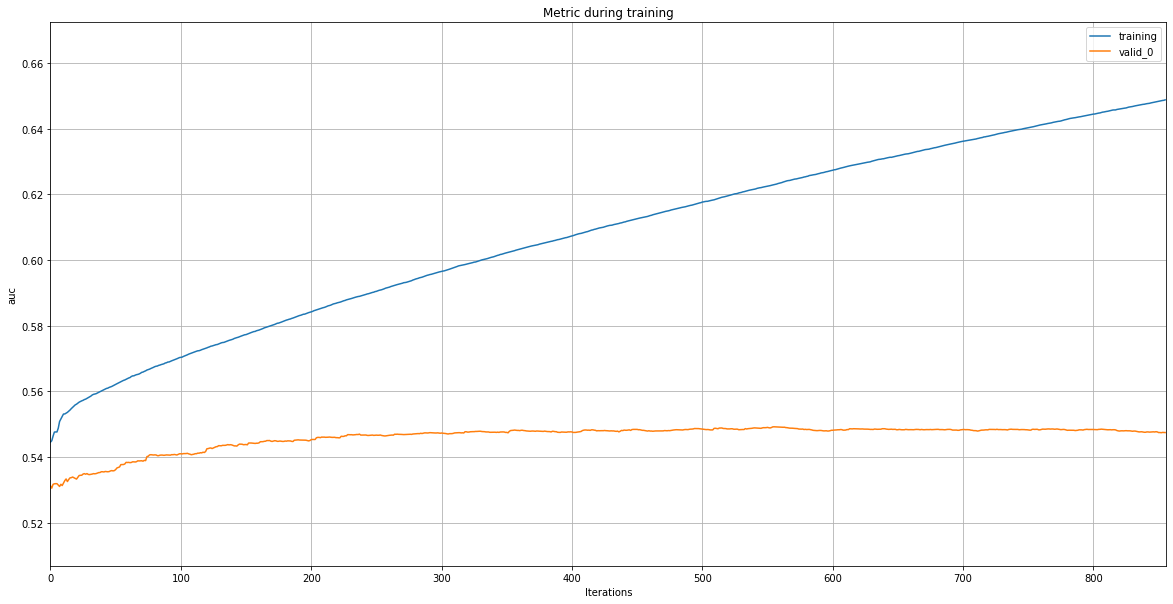

In [21]:
lgb.plot_metric(evals_result, metric='auc', figsize=(20,10))

In [132]:
print('LightGBM prediction classification report\n')
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
print(classification_report(y_test, y_pred > 0.5))

LightGBM prediction classification report

              precision    recall  f1-score   support

       False       0.53      0.59      0.56      3189
        True       0.54      0.48      0.51      3211

    accuracy                           0.54      6400
   macro avg       0.54      0.54      0.53      6400
weighted avg       0.54      0.54      0.53      6400



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ALEX\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


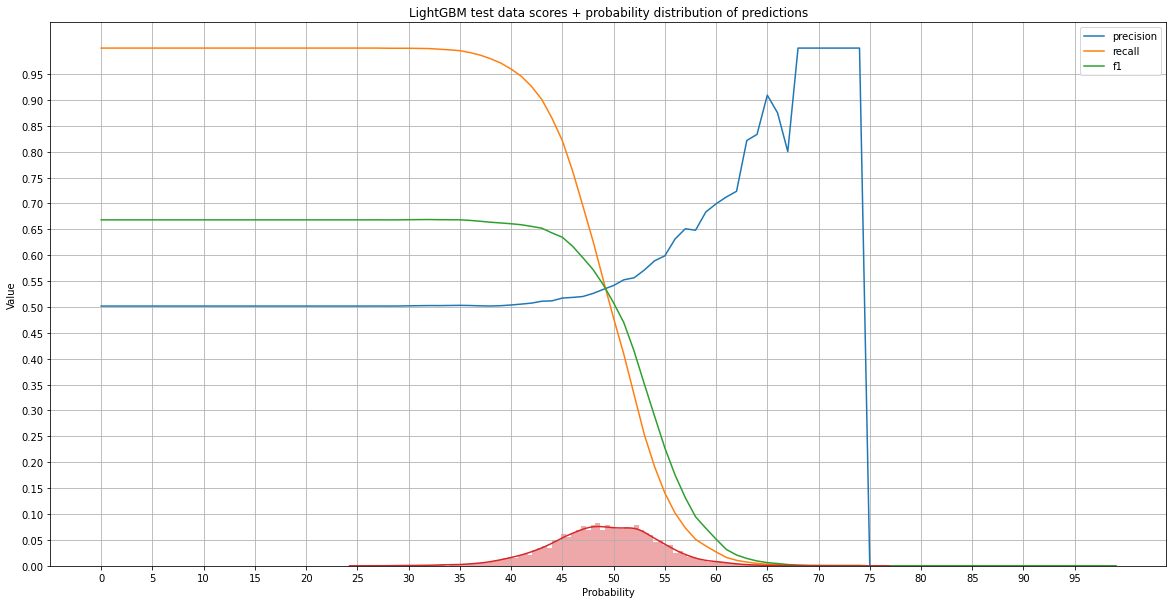

In [141]:
f1 =[]; recall = []; precision = []
for i in np.arange(0,1,0.01):
    precision.append(precision_score(y_test, y_pred > i))
    recall.append(recall_score(y_test, y_pred > i))
    f1.append(f1_score(y_test, y_pred > i))
    
plt.figure(figsize=(20,10))
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.plot(f1, label='f1')
sns.distplot(y_pred*100, bins= 100)
plt.title('LightGBM test data scores + probability distribution of predictions')
plt.xlabel('Probability')
plt.ylabel('Value')
plt.xticks(range(0,100,5))
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.legend()

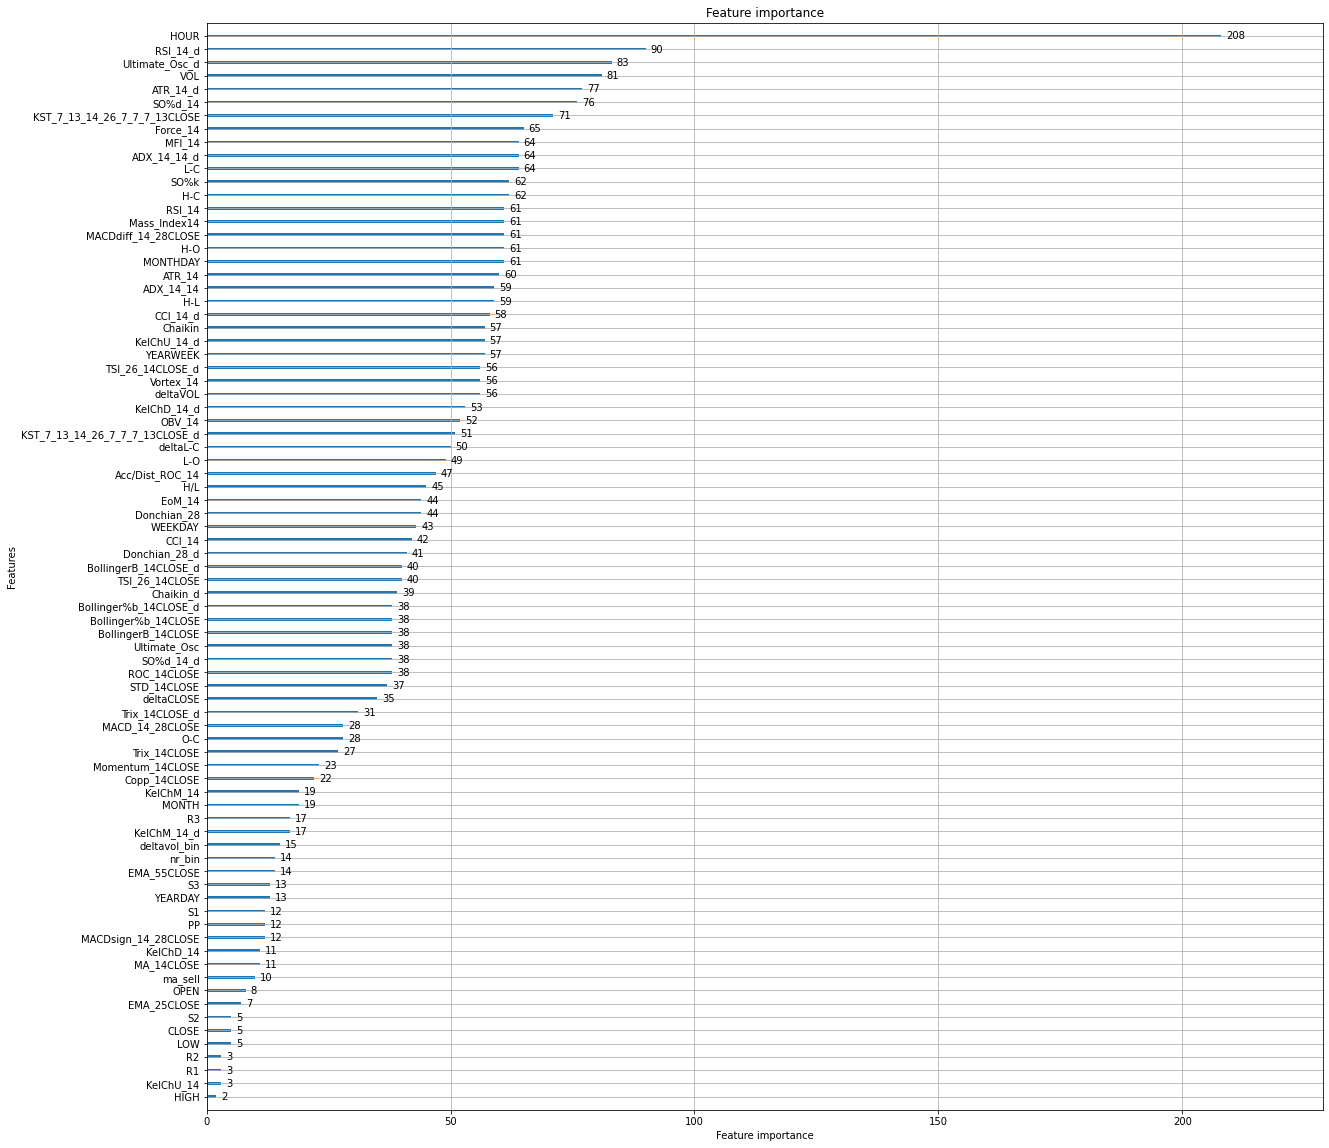

In [134]:
ax = lgb.plot_importance(gbm,figsize=(20,20))
importances_list = ax.get_yticklabels()

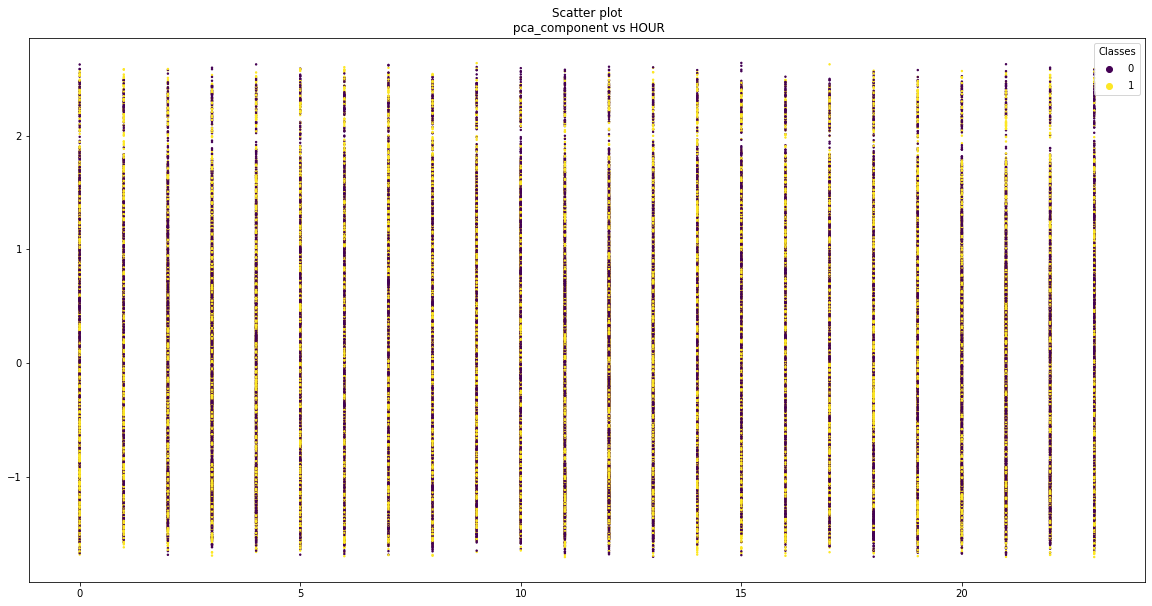

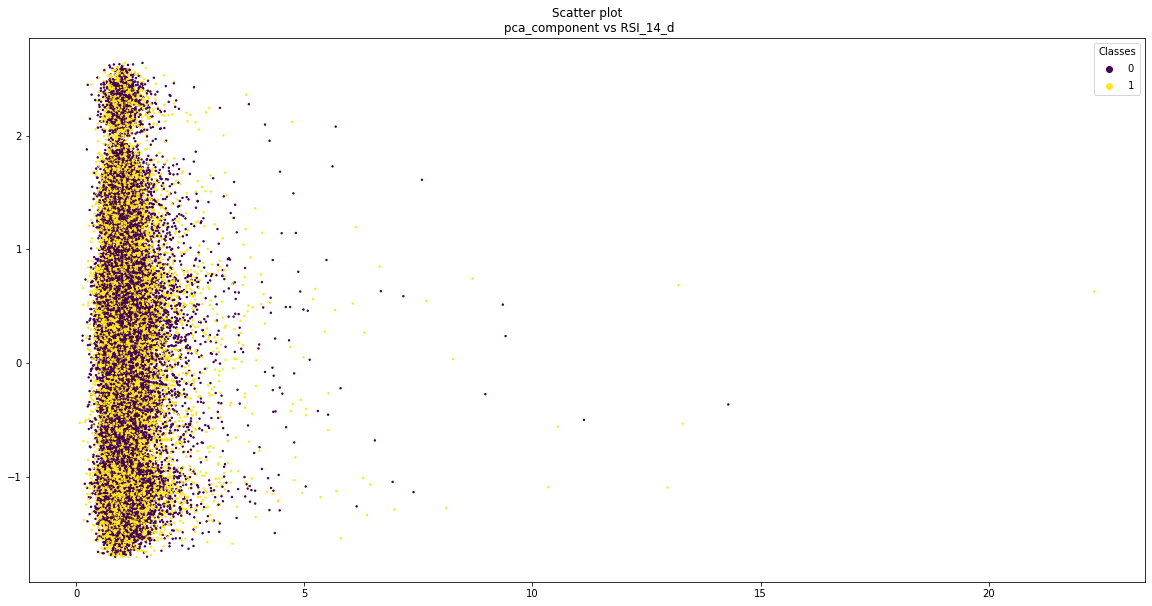

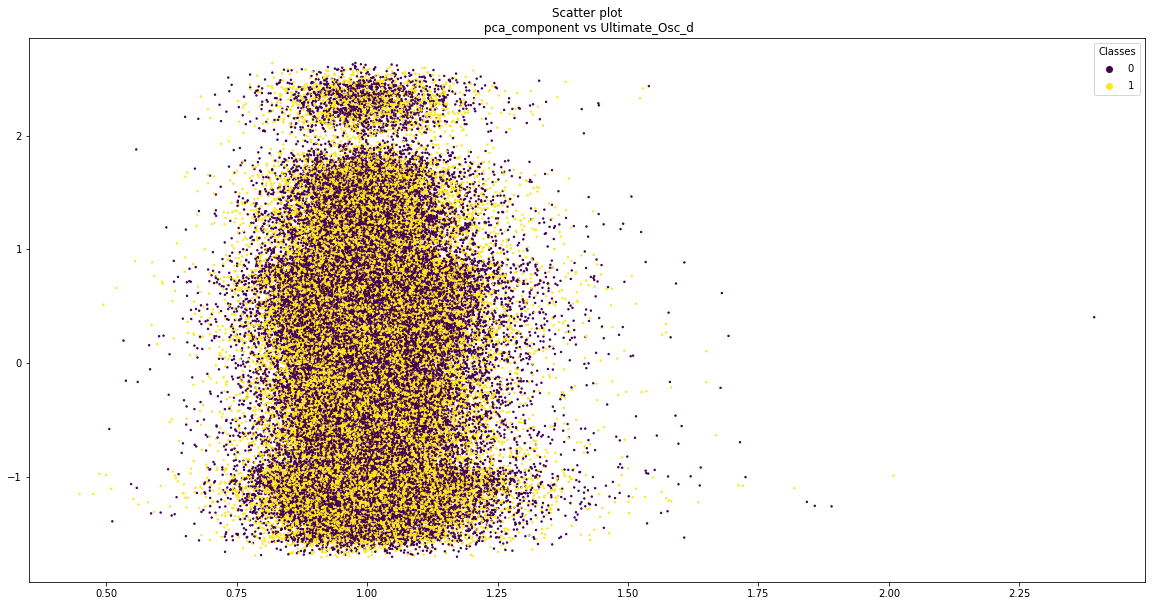

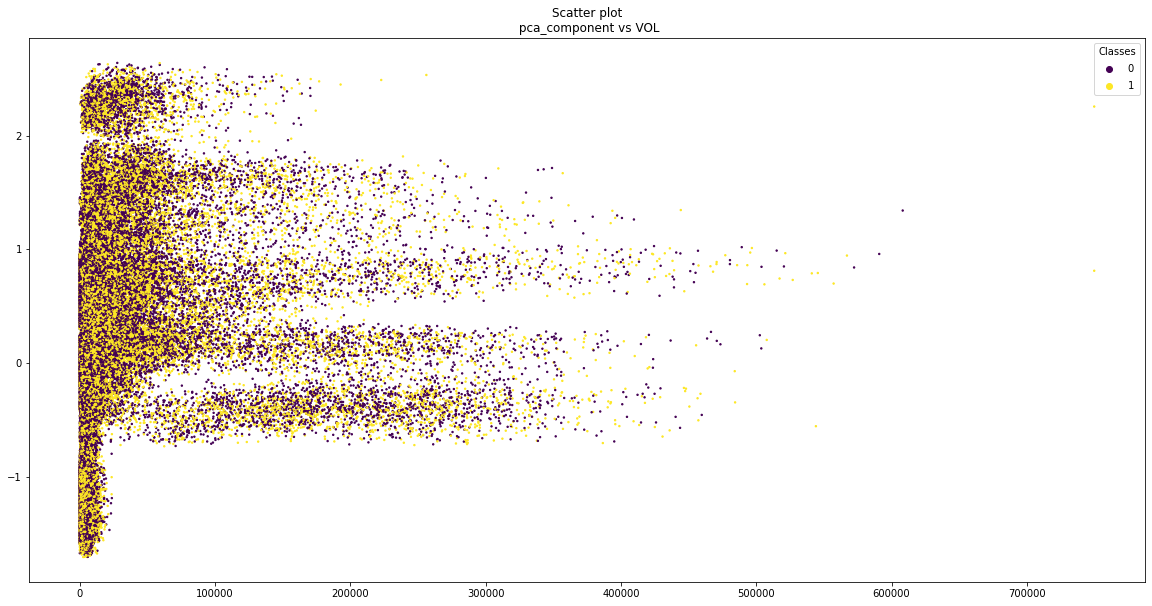

In [25]:
    # Let's see, is the data separable
    # Use PCA component as feature  
drop_columns = ['DATE','y']
sc = ColumnTransformer(transformers=[('drop', 'drop', drop_columns),
                                      ('num', MinMaxScaler(), [x for x in data.columns.to_list() if x not in drop_columns])
                                    ])
x_scaled = sc.fit_transform(data)
pca_component = PCA(n_components=1).fit_transform(x_scaled)
for i in np.arange(-1,-5,-1):
   feature_name = str(importances_list[i]).split("'")[1]
   plt.figure(figsize=(20,10))
   scatter = plt.scatter(data.loc[:,feature_name], pca_component, c=data.y, s=2)
   plt.title('Scatter plot\n pca_component vs %s' % feature_name)
   plt.legend(*scatter.legend_elements(), title="Classes")

# Using PCA shows data low separability

In [26]:
    # Next learn tensorflow RNN model with LSTM layers
    
    # Reduce dimensionality in features space for faster grid search
    # Use Pearson's correlation
def corr_df(x, corr_val=0.8):
    #Obj: Drops features that are strongly correlated to other features.
    #Inputs: x = Pandas dataframe
    #        corr_val=(0..1): Columns are dropped relative to the corr_val input (e.g. 0.8)
    #Output: dataframe that only includes uncorrelated features
     corr_matrix = x.corr()
     iters = range(len(corr_matrix.columns) - 1)
     drop_cols = []
    # Iterates through Correlation Matrix Table to find correlated columns
     for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                drop_cols.append(i)
     drops = sorted(set(drop_cols))[::-1]
    # Drops the correlated columns
     for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
     return x, drops

    # Function to create 3-dimensional dataset, required for LSTM layer
def create_3d_dataset(x,y, look_back=48):
   dataX, dataY = [], []
   for i in range(x.shape[0]-look_back-1):
        dataX.append(np.array(x[i:(i+look_back)]))
        dataY.append(y[i + look_back-1])
   return np.array(dataX), np.array(dataY)

In [27]:
data_reduced, drops = corr_df(data.drop(drop_columns, axis=1))
print('Dropped %d columns: ' % len(drops), data.columns[drops].values)
print('\nShape of reduced dataframe: ', data_reduced.shape)
data_reduced

Dropped 31 columns:  ['S2' 'R2' 'S1' 'R1' 'PP' 'EoM_14' 'Force_14' 'STD_14CLOSE' 'KelChM_14_d'
 'KelChD_14' 'KelChU_14' 'KelChM_14' 'Copp_14CLOSE' 'CCI_14_d' 'CCI_14'
 'RSI_14' 'KST_7_13_14_26_7_7_7_13CLOSE' 'Mass Index14'
 'MACDdiff_14_28CLOSE' 'MACD_14_28CLOSE' 'ADX_14_14_d' 'ADX_14_14' 'SO%k'
 'MA_14CLOSE' 'deltaCLOSE' 'deltaVOL' 'L-C' 'WEEKDAY' 'MONTHDAY' 'HIGH'
 'OPEN']

Shape of reduced dataframe:  (104448, 55)


,OPEN,HIGH,VOL,HOUR,VOL_log,MONTH,YEARWEEK,MONTHDAY,WEEKDAY,H/L,L-C,deltaL-C,O-C,H-O,H-C,L-O,deltaVOL,deltaCLOSE,Momentum_14CLOSE,ROC_14CLOSE,ATR_14,ATR_14_d,SO%k,SO%d_14,Trix_14CLOSE,Trix_14CLOSE_d,ADX_14_14,ADX_14_14_d,Mass Index14,KST_7_13_14_26_7_7_7_13CLOSE_d,RSI_14_d,TSI_26_14CLOSE_d,CCI_14,CCI_14_d,Ultimate_Osc,Ultimate_Osc_d,Donchian_28,Donchian_28_d,STD_14CLOSE,BollingerB_14CLOSE,BollingerB_14CLOSE_d,Bollinger%b_14CLOSE_d,Acc/Dist_ROC_14,Chaikin,Chaikin_d,MFI_14,OBV_14,Force_14,EoM_14,nr_bin,ma_buy,ma_sell,deltavol_bin,sell,buy
0,1.13420,1.13490,393.0,22,5.973810,7,31,30,2,1.000882,-0.00050,0.00010,-0.00020,0.00070,0.00050,-0.00030,-57.0,0.00020,-0.00890,-0.007784,0.002670,1.031538,0.500000,0.379698,-0.000292,1.080949,0.623847,1.052510,42.553252,1.043098,0.733075,1.037696,-1.481864,0.147982,2.604516,0.976595,0.00910,1.000000,0.003588,0.012597,1.052835,2.153178,-1.000000,8.152226,-0.106810,0.216760,-294.928571,0.93450,-4.099901e-09,False,False,False,False,False,True
1,1.13430,1.13750,451.0,23,6.111467,7,31,30,2,1.002910,-0.00160,-0.00110,-0.00150,0.00320,0.00170,-0.00010,58.0,0.00140,-0.00750,-0.007255,0.002447,0.916611,0.484848,0.393718,-0.000314,1.072835,0.571138,0.915510,42.751472,1.015468,1.000000,0.977312,-0.937390,0.544474,2.550479,0.979253,0.00910,1.000000,0.003528,0.012389,0.983517,1.882023,-1.090093,37.621200,4.614838,0.216760,-231.285714,0.42000,-3.395597e-09,False,False,False,False,False,True
2,1.13570,1.13630,410.0,0,6.016157,7,31,31,3,1.001763,-0.00080,0.00080,0.00060,0.00060,0.00120,-0.00140,-41.0,-0.00070,-0.00900,-0.007606,0.002561,1.046487,0.400000,0.394556,-0.000330,1.051745,0.525460,0.920023,42.927727,1.008340,4.435624,0.990082,-0.973471,-0.036081,2.812593,1.102770,0.00910,1.000000,0.003323,0.011676,0.942413,0.936071,-0.724130,24.514160,0.651605,0.222078,-199.071429,0.75600,-3.559762e-09,False,False,False,False,True,False
3,1.13510,1.13600,409.0,1,6.013715,7,31,31,3,1.001764,-0.00060,0.00020,0.00050,0.00090,0.00140,-0.00110,-1.0,-0.00050,-0.00920,-0.008043,0.002486,0.970806,0.300000,0.381948,-0.000343,1.038869,0.490798,0.934034,43.045181,1.027745,1.000000,0.998034,-0.977110,-0.003640,2.766337,0.983554,0.01070,1.175824,0.003041,0.010694,0.915899,0.965273,-3.076610,-9.040002,-0.368767,0.151392,-263.642857,0.82800,-3.859223e-09,False,False,False,False,True,False
4,1.13460,1.13630,431.0,2,6.066108,7,31,31,3,1.001852,-0.00150,-0.00090,-0.00110,0.00170,0.00060,-0.00040,22.0,0.00110,-0.00810,-0.005691,0.002421,0.973938,0.714286,0.426261,-0.000353,1.029801,0.451927,0.920801,43.011524,1.000856,0.952143,0.958500,-0.714126,0.262984,2.477275,0.895507,0.01130,1.056075,0.002494,0.008773,0.820381,1.450924,-3.625124,88.882368,-9.832118,0.078613,-257.214286,0.47790,-3.601662e-09,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104443,1.14453,1.14492,4586.0,15,8.430763,7,30,20,0,1.003005,-0.00028,-0.00016,0.00276,0.00039,0.00315,-0.00304,422.0,-0.00277,-0.00172,-0.002080,0.001643,1.028645,0.081633,0.430435,0.000130,1.017467,0.300537,0.956520,41.805035,0.866631,1.037704,0.746764,-0.776563,-1.529424,3.787919,0.833032,0.00714,1.000000,0.001695,0.005925,1.067717,0.319579,-1.567067,-1911.541032,1.225030,0.523676,-117.500000,-4.73516,5.083642e-11,False,False,False,False,True,False
104444,1.14176,1.14285,6423.0,16,8.767641,7,30,20,0,1.002359,-0.00166,-0.00138,-0.00006,0.00109,0.00103,-0.00160,1837.0,0.00005,-0.00233,-0.000298,0.001881,1.145077,0.617100,0.455324,0.000124,0.955321,0.306956,1.021359,41.905367,0.891249,0.598568,0.735413,-1.288013,-0.511450,2.934733,0.774761,0.00714,1.000000,0.001780,0.006226,1.050748,1.244929,-1.118717,-181.832046,0.095123,0.397394,-576.000000,-12.55171,-6.893768e-11,False,False,False,True,False,True
104445,1.14178,1.14435,5674.0,17,8.643650,7,30,20,0,1.002910,-0.00286,-0.00120,-0.00211,0.

In [135]:
    # Prepare data for training and testing
bool_features = ['nr_bin','ma_buy','ma_sell','deltavol_bin','sell','buy']
numeric_features = [x for x in data_reduced.columns.to_list() if x not in bool_features+drop_columns]
scaler = ColumnTransformer(transformers=[('bool', 'passthrough', bool_features),
                                         ('num', MinMaxScaler(), numeric_features)])
x_scaled = scaler.fit_transform(data_reduced)
x_scaled = x_scaled.astype(float)

joblib.dump(scaler,path+'scaler_'+str(data_reduced.shape[1])+'_features')
print('x_scaled.shape = ',x_scaled.shape)
x, y = create_3d_dataset(x_scaled,data.y)
x_train = x[:-test_size]
y_train = y[:-test_size]
x_test =  x[-test_size:]
y_test  = y[-test_size:]
print('x_train.dtype = ', x_train.dtype)
print('x_train.shape = ',x_train.shape,' y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape,' y_test.shape = ',y_test.shape)

x_scaled.shape =  (104448, 55)
x_train.dtype =  float64
x_train.shape =  (97999, 48, 55)  y_train.shape =  (97999,)
x_test.shape =  (6400, 48, 55)  y_test.shape =  (6400,)


In [29]:
    # Function to create model, required for KerasClassifier
def create_model(optimizer='adam', init='glorot_uniform', activation='sigmoid', lr=0.02, obj='LSTM', r_drop=0.0, units=16):
     K.clear_session()
     model = Sequential()
     if obj == 'GRU':
        model.add(GRU(units, kernel_initializer=init, activation=activation, return_sequences=True,
                      recurrent_dropout = r_drop,
                      input_shape=(x_train.shape[1],x_train.shape[2]) ))
        model.add(GRU(4, kernel_initializer=init, activation=activation, return_sequences=False,
                  recurrent_dropout = r_drop ))        
     else:
        model.add(LSTM(units, kernel_initializer=init, activation=activation, return_sequences=True,
                       recurrent_dropout = r_drop,
                       input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(LSTM(4, kernel_initializer=init, activation=activation, return_sequences=False,
                       recurrent_dropout = r_drop ))
     model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
     auc = keras.metrics.AUC()
     model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=[auc])
     model.optimizer.lr = lr
     return model

In [31]:
n_splits = 7
    # Use GridSearchCV to find optimal hyperparameters
param_grid= {'obj': ['LSTM'],
             'optimizer': ['adam'],
             'activation': ['sigmoid', 'relu'],
             'r_drop': [0.01, 0.1, 0.2],
             'units': [(x_train.shape[2]//2)],
             'init': ['glorot_uniform'],
             'epochs': [50],
             'batch_size': [16, 32]
             }
grid_search = GridSearchCV(KerasClassifier(build_fn=create_model, verbose=1),
                           param_grid, cv=TimeSeriesSplit(n_splits=n_splits), scoring='roc_auc', n_jobs=-1, return_train_score=True)
now=datetime.now()
current_time=now.strftime("%d/%m/%y %H:%M:%S")
print('KerasClassifier start time = ',current_time)
start = time()
with warnings.catch_warnings():
   warnings.filterwarnings('ignore')
   grid_result = grid_search.fit(x_train, y_train)
print('\nPassed %.1f hours\n'%((time() - start)/3600))
print('CV best AUC: %.4f, Test AUC: %.4f'%(grid_result.best_score_, grid_result.score(x_test,y_test)))
print('Best params: ', grid_result.best_params_)

KerasClassifier start time =  03/04/21 11:12:09
Epoch 1/50
3063/3063 [==============================] - 87s 27ms/step - loss: 0.6935 - auc: 0.5122
Epoch 2/50
3063/3063 [==============================] - 78s 25ms/step - loss: 0.6919 - auc: 0.5244
Epoch 3/50
3063/3063 [==============================] - 78s 25ms/step - loss: 0.6917 - auc: 0.5310
Epoch 4/50
3063/3063 [==============================] - 77s 25ms/step - loss: 0.6913 - auc: 0.5330
Epoch 5/50
3063/3063 [==============================] - 77s 25ms/step - loss: 0.6913 - auc: 0.5329
Epoch 6/50
3063/3063 [==============================] - 77s 25ms/step - loss: 0.6912 - auc: 0.5323
Epoch 7/50
3063/3063 [==============================] - 77s 25ms/step - loss: 0.6906 - auc: 0.5379
Epoch 8/50
3063/3063 [==============================] - 78s 26ms/step - loss: 0.6911 - auc: 0.5334
Epoch 9/50
3063/3063 [==============================] - 78s 26ms/step - loss: 0.6911 - auc: 0.5341
Epoch 10/50
3063/3063 [==============================] - 78s 

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


200/200 [==============================] - 1s 4ms/step
CV best AUC: 0.5331, Test AUC: 0.5298
Best params:  {'activation': 'sigmoid', 'batch_size': 32, 'epochs': 50, 'init': 'glorot_uniform', 'obj': 'LSTM', 'optimizer': 'adam', 'r_drop': 0.1, 'units': 27}


Max mean_test_score =  0.5331228828375886


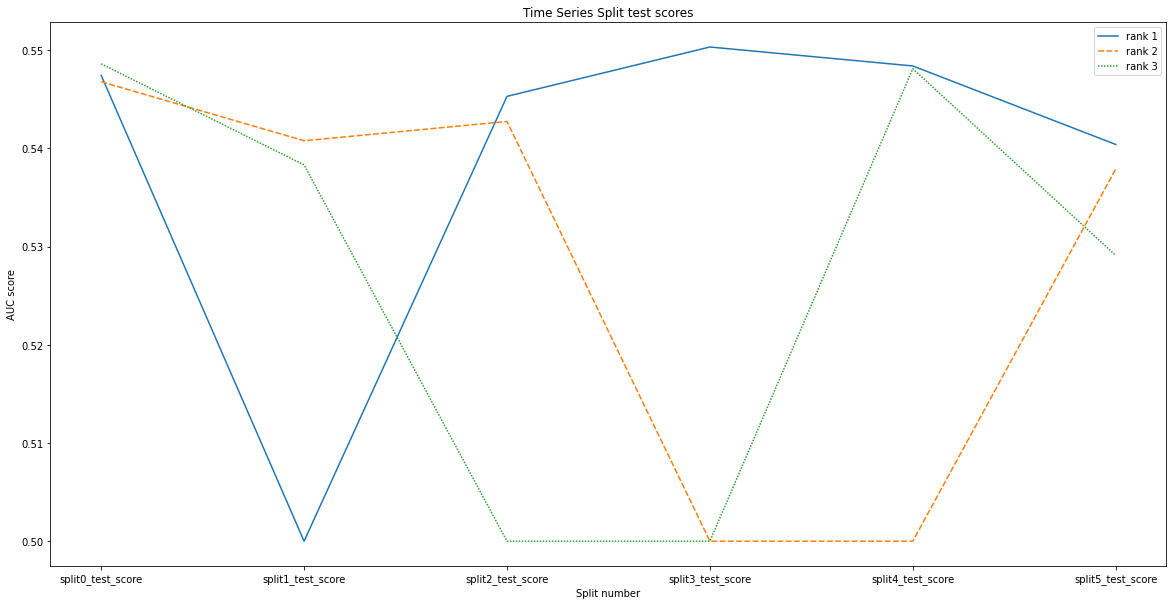

In [49]:
def plot_gs_split_score(gs_results):
    result = pd.DataFrame(gs_results).sort_values('mean_test_score', axis=0, ascending=False).reset_index(drop=True)
    print('Max mean_test_score = ', result['mean_test_score'][0])
    col_list =[]
    for i in range(n_splits-1):
        col_list.append('split%s_test_score'%str(i))
    result = result[col_list].T.iloc[:,0:3]
    result.rename(columns = {0: 'rank 1', 1: 'rank 2', 2: 'rank 3'}, inplace = True)
    plt.figure(figsize=(20,10))
    g = sns.lineplot(data = result)
    g.set_title('Time Series Split test scores')
    g.set(xlabel='Split number', ylabel='AUC score')
    return

plot_gs_split_score(grid_result.cv_results_)

In [43]:
    # Repeat GridSearchCV for more accurate parameters tuning
param_grid = grid_result.best_params_.copy()
for x in param_grid.keys():
   param_grid[x] = [param_grid[x]]
param_grid['batch_size'] = [32, 64, 128, 256]
param_grid['r_drop'] = [0.05, 0.1, 0.15, 0.2]

grid_search = GridSearchCV(KerasClassifier(build_fn=create_model, verbose=1),
                           param_grid, cv=TimeSeriesSplit(n_splits=n_splits), scoring='roc_auc', n_jobs=-1, return_train_score=True)
now=datetime.now()
current_time=now.strftime("%d/%m/%y %H:%M:%S")
print('KerasClassifier start time with new param_grid = ',current_time)
start = time()
with warnings.catch_warnings():
   warnings.filterwarnings('ignore')
   grid_result2 = grid_search.fit(x_train, y_train)
print('\nPassed %.1f hours\n'%((time() - start)/3600))
print('CV best AUC: %.4f, Test AUC: %.4f'%(grid_result2.best_score_, grid_result2.score(x_test,y_test)))
print('Best params: ', grid_result2.best_params_)

KerasClassifier start time with new param_grid =  05/04/21 08:47:27
Epoch 1/50
1532/1532 [==============================] - 48s 27ms/step - loss: 0.6926 - auc: 0.5191
Epoch 2/50
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6906 - auc: 0.5363
Epoch 3/50
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6906 - auc: 0.5386
Epoch 4/50
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6902 - auc: 0.5414
Epoch 5/50
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6900 - auc: 0.5413
Epoch 6/50
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6900 - auc: 0.5404
Epoch 7/50
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6896 - auc: 0.5448
Epoch 8/50
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6897 - auc: 0.5447
Epoch 9/50
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6899 - auc: 0.5426
Epoch 10/50
1532/1532 [==================

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


100/100 [==============================] - 1s 5ms/step
CV best AUC: 0.5460, Test AUC: 0.5344
Best params:  {'activation': 'sigmoid', 'batch_size': 64, 'epochs': 50, 'init': 'glorot_uniform', 'obj': 'LSTM', 'optimizer': 'adam', 'r_drop': 0.1, 'units': 27}


Max mean_test_score =  0.5460371555484187


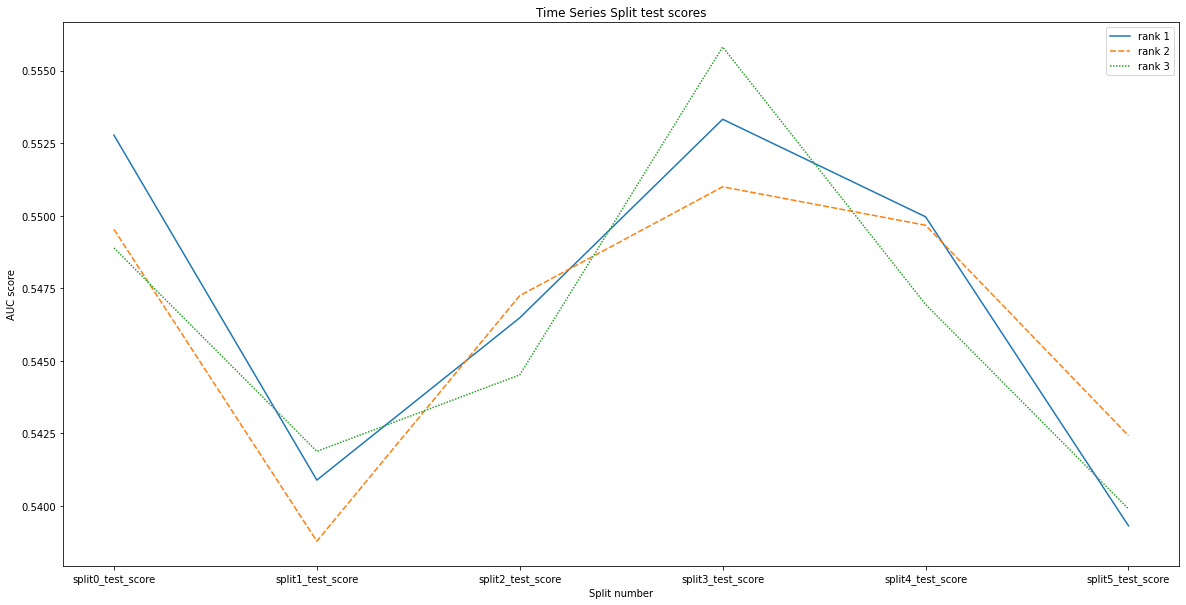

In [50]:
plot_gs_split_score(grid_result2.cv_results_)

In [53]:
best_params = grid_result2.best_params_.copy()
del best_params['batch_size']
del best_params['epochs']
rnn = create_model(**best_params)

now=datetime.now()
current_time=now.strftime("%d/%m/%y %H:%M:%S")
print('KerasClassifier start time with more epochs = ',current_time)
start = time()
    # Save the best weight during training.
checkpoint = ModelCheckpoint(path+'TF-KERAS-%s-lr02-weights-best.hdf5'%grid_result2.best_params_['obj'],
                             monitor='val_auc', verbose=1, save_best_only=True, mode='max', save_freq='epoch')
early_stop = keras.callbacks.EarlyStopping(monitor='auc', mode='max', patience=30, restore_best_weights=True)
callbacks_list = [checkpoint, early_stop]

history = rnn.fit(x_train, y_train, epochs=150, batch_size=grid_result2.best_params_['batch_size'],
                  verbose=1, callbacks=callbacks_list, validation_data=(x_test, y_test))
print('Passed %.1f hours'%((time() - start)/3600))
rnn.save(path+'TF-KERAS-%s-lr%s.h5' % (grid_result2.best_params_['obj'],
                                       str(K.eval(rnn.optimizer.lr)).split('.')[1]))

KerasClassifier start time with more epochs =  06/04/21 21:19:10
Epoch 1/150
1532/1532 [==============================] - 48s 28ms/step - loss: 0.6932 - auc: 0.5059 - val_loss: 0.6944 - val_auc: 0.5316

Epoch 00001: val_auc improved from -inf to 0.53161, saving model to C:\Users\ALEX\Documents\PythonScripts\1H-model-ver7.1-binary-1h-preds\TF-KERAS-LSTM-lr02-weights-best.hdf5
Epoch 2/150
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6910 - auc: 0.5313 - val_loss: 0.6950 - val_auc: 0.5314

Epoch 00002: val_auc did not improve from 0.53161
Epoch 3/150
1532/1532 [==============================] - 44s 28ms/step - loss: 0.6912 - auc: 0.5325 - val_loss: 0.6925 - val_auc: 0.5270

Epoch 00003: val_auc did not improve from 0.53161
Epoch 4/150
1532/1532 [==============================] - 43s 28ms/step - loss: 0.6904 - auc: 0.5376 - val_loss: 0.6923 - val_auc: 0.5311

Epoch 00004: val_auc did not improve from 0.53161
Epoch 5/150
1532/1532 [==============================] - 4

1532/1532 [==============================] - 44s 29ms/step - loss: 0.6898 - auc: 0.5431 - val_loss: 0.6917 - val_auc: 0.5354

Epoch 00040: val_auc did not improve from 0.53630
Epoch 41/150
1532/1532 [==============================] - 44s 29ms/step - loss: 0.6906 - auc: 0.5337 - val_loss: 0.6931 - val_auc: 0.5290

Epoch 00041: val_auc did not improve from 0.53630
Epoch 42/150
1532/1532 [==============================] - 44s 29ms/step - loss: 0.6895 - auc: 0.5442 - val_loss: 0.6941 - val_auc: 0.5303

Epoch 00042: val_auc did not improve from 0.53630
Epoch 43/150
1532/1532 [==============================] - 44s 29ms/step - loss: 0.6901 - auc: 0.5393 - val_loss: 0.6918 - val_auc: 0.5317

Epoch 00043: val_auc did not improve from 0.53630
Epoch 44/150
1532/1532 [==============================] - 44s 29ms/step - loss: 0.6896 - auc: 0.5453 - val_loss: 0.6952 - val_auc: 0.5342

Epoch 00044: val_auc did not improve from 0.53630
Epoch 45/150
1532/1532 [==============================] - 44s 29ms/s

200/200 [==============================] - 2s 5ms/step - loss: 0.6926 - auc: 0.5316
Test AUC: 0.5316


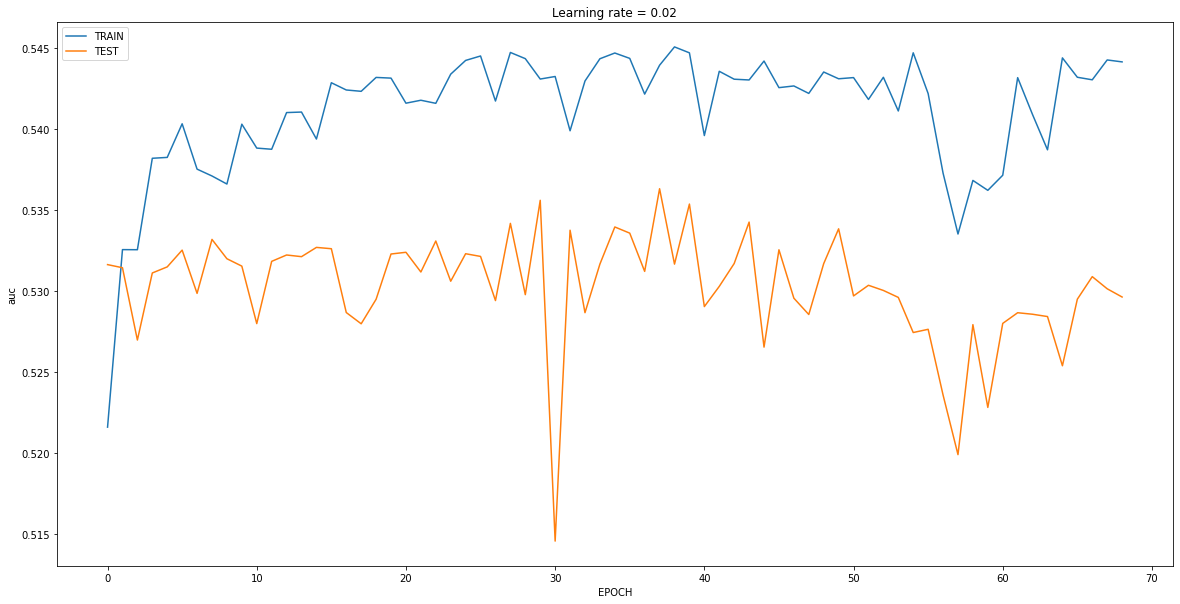

In [54]:
# joblib.load
loss, auc = rnn.evaluate(x_test, y_test)
print('Test AUC: %.4f' % auc)

metric = 'auc'
for k in list(history.history.keys()):
    if metric in k and 'val' not in k:
        plt.figure(figsize=(20,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.ylabel(metric)
        plt.xlabel('EPOCH')
        plt.title('Learning rate = %s' % str(K.eval(rnn.optimizer.lr)))
        plt.legend(['TRAIN', 'TEST'])

# Decaying learning rate

In [66]:
    # Load the weight that worked the best
rnn_lr = create_model(**best_params)
rnn_lr.load_weights(path+'TF-KERAS-%s-lr02-weights-best.hdf5'%grid_result2.best_params_['obj'])

    # Train again with decaying learning rate
def scheduler(epoch):
 if (epoch%10) == 0 and epoch != 0:
  lr = K.get_value(rnn_lr.optimizer.lr)
  K.set_value(rnn_lr.optimizer.lr, lr*.5)
  print("lr changed to %f" %(lr*.5))
 return K.get_value(rnn_lr.optimizer.lr)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

now=datetime.now()
current_time=now.strftime("%d/%m/%y %H:%M:%S")
print('Start time = ',current_time)
start = time()
checkpoint = ModelCheckpoint(path+'TF-KERAS-%s-lr%s-weights-best.hdf5'%
                             (grid_result2.best_params_['obj'], str(K.eval(rnn_lr.optimizer.lr)).split('.')[1]),
                             monitor='val_auc', verbose=1, save_best_only=True, mode='max', save_freq='epoch')
callbacks_list = [checkpoint, lr_decay, early_stop]
history_lr = rnn_lr.fit(x_train, y_train, epochs=150, batch_size=grid_result2.best_params_['batch_size'],
                        verbose=1, callbacks=callbacks_list, validation_data=(x_test, y_test))
print('Passed %.1f hours'%((time() - start)/3600))
rnn_lr.save(path+'TF-KERAS-%s-lr%s.h5' % (grid_result2.best_params_['obj'], str(K.eval(rnn_lr.optimizer.lr)).split('.')[1]))

Start time =  06/04/21 22:20:35
Epoch 1/150
1532/1532 [==============================] - 50s 29ms/step - loss: 0.6894 - auc: 0.5444 - val_loss: 0.6948 - val_auc: 0.5322

Epoch 00001: val_auc improved from -inf to 0.53215, saving model to C:\Users\ALEX\Documents\PythonScripts\1H-model-ver7.1-binary-1h-preds\TF-KERAS-LSTM-lr02-weights-best.hdf5
Epoch 2/150
1532/1532 [==============================] - 44s 29ms/step - loss: 0.6896 - auc: 0.5429 - val_loss: 0.6960 - val_auc: 0.5299

Epoch 00002: val_auc did not improve from 0.53215
Epoch 3/150
1532/1532 [==============================] - 44s 29ms/step - loss: 0.6899 - auc: 0.5432 - val_loss: 0.6920 - val_auc: 0.5311

Epoch 00003: val_auc did not improve from 0.53215
Epoch 4/150
1532/1532 [==============================] - 45s 29ms/step - loss: 0.6896 - auc: 0.5442 - val_loss: 0.6923 - val_auc: 0.5296

Epoch 00004: val_auc did not improve from 0.53215
Epoch 5/150
1532/1532 [==============================] - 45s 29ms/step - loss: 0.6895 - auc

1532/1532 [==============================] - 45s 29ms/step - loss: 0.6873 - auc: 0.5566 - val_loss: 0.6927 - val_auc: 0.5328

Epoch 00080: val_auc did not improve from 0.53328
Epoch 81/150
lr changed to 0.000078
1532/1532 [==============================] - 45s 29ms/step - loss: 0.6875 - auc: 0.5554 - val_loss: 0.6927 - val_auc: 0.5328

Epoch 00081: val_auc did not improve from 0.53328
Epoch 82/150
1532/1532 [==============================] - 44s 29ms/step - loss: 0.6873 - auc: 0.5571 - val_loss: 0.6928 - val_auc: 0.5329

Epoch 00082: val_auc did not improve from 0.53328
Epoch 83/150
1532/1532 [==============================] - 45s 29ms/step - loss: 0.6875 - auc: 0.5559 - val_loss: 0.6927 - val_auc: 0.5331

Epoch 00083: val_auc did not improve from 0.53328
Epoch 84/150
1532/1532 [==============================] - 44s 29ms/step - loss: 0.6878 - auc: 0.5548 - val_loss: 0.6927 - val_auc: 0.5330

Epoch 00084: val_auc did not improve from 0.53328
Epoch 85/150
1532/1532 [=====================

200/200 [==============================] - 2s 5ms/step - loss: 0.6928 - auc: 0.5329
rnn_lr has test AUC: 0.5329


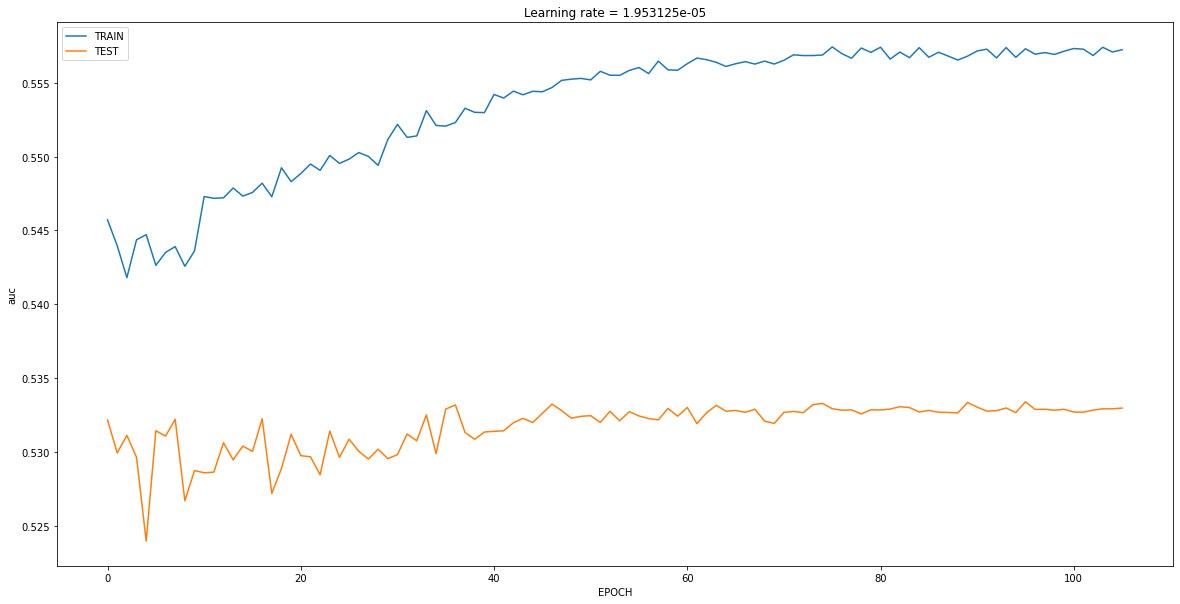

In [67]:
loss, auc = rnn_lr.evaluate(x_test, y_test)
print('rnn_lr has test AUC: %.4f' % auc)

metric = 'auc'
for k in list(history_lr.history.keys()):
    if metric in k and 'val' not in k:
        plt.figure(figsize=(20,10))
        plt.plot(history_lr.history[k])
        plt.plot(history_lr.history['val_' + k])
        plt.ylabel(metric)
        plt.xlabel('EPOCH')
        plt.title('Learning rate = %s' % str(K.eval(rnn_lr.optimizer.lr)))
        plt.legend(['TRAIN', 'TEST'])

In [136]:
y_pred = rnn_lr.predict(x_test)
print('Keras RNN test data classification report with probability threshold = 0.5 \n')
print(classification_report(y_test, y_pred > 0.5))

Keras RNN test data classification report with probability threshold = 0.5 

              precision    recall  f1-score   support

       False       0.51      0.63      0.57      3188
        True       0.53      0.41      0.46      3212

    accuracy                           0.52      6400
   macro avg       0.52      0.52      0.51      6400
weighted avg       0.52      0.52      0.51      6400



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ALEX\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


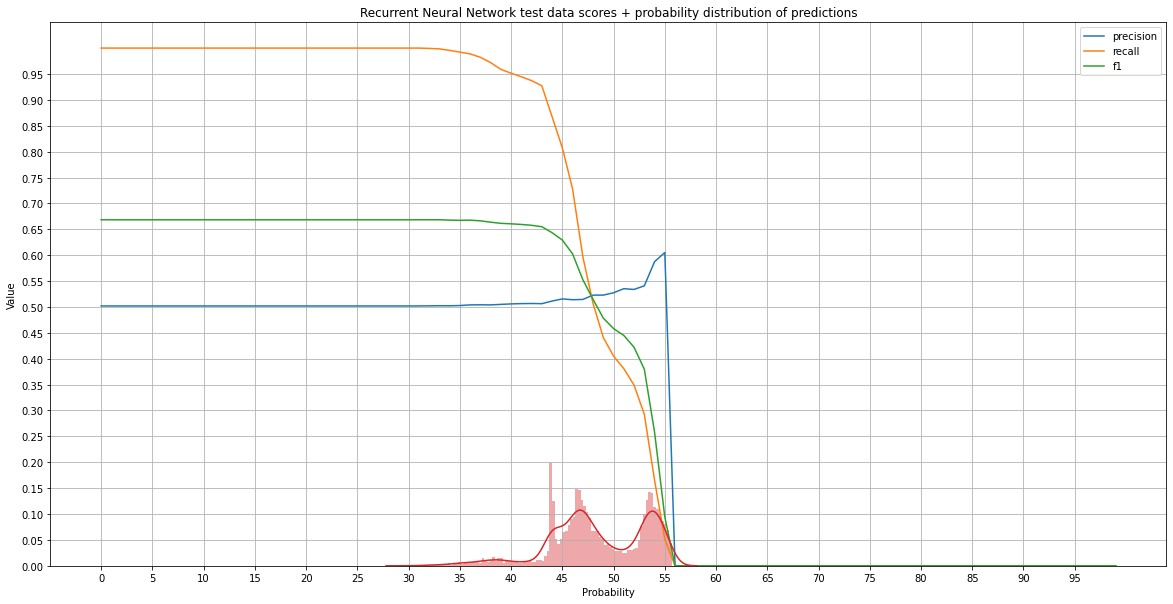

In [137]:
f1 =[]; recall = []; precision = []
for i in np.arange(0,1,0.01):
    precision.append(precision_score(y_test, y_pred > i))
    recall.append(recall_score(y_test, y_pred > i))
    f1.append(f1_score(y_test, y_pred > i))
    
plt.figure(figsize=(20,10))
plt.plot(precision, label='precision')
plt.plot(recall, label='recall')
plt.plot(f1, label='f1')
sns.distplot(y_pred*100, bins= 100)
plt.title('Recurrent Neural Network test data scores + probability distribution of predictions')
plt.xlabel('Probability')
plt.ylabel('Value')
plt.xticks(range(0,100,5))
plt.yticks(np.arange(0,1,0.05))
plt.grid()
plt.legend()

In [22]:
def classification_report2(threshold, y_pred):
  print('Probability range (0, '+str(threshold)+') contains number of samples = '+
        str(round(100*(y_pred<threshold).sum()/len(y_pred), 1))+'%')
  print('Classification report with probability threshold = %.2f \n'%threshold)
  print(classification_report(y_test, y_pred > threshold))
  print('------------------------------------------------------')

print('Keras RNN')
classification_report2(0.4, y_pred)
classification_report2(0.45, y_pred)

Keras RNN
Probability range (0, 0.4) contains number of samples = 4.4%
Classification report with probability threshold = 0.40 

              precision    recall  f1-score   support

       False       0.07      0.01      0.01      3189
        True       0.48      0.92      0.63      3211

    accuracy                           0.46      6400
   macro avg       0.28      0.46      0.32      6400
weighted avg       0.28      0.46      0.32      6400

------------------------------------------------------
Probability range (0, 0.45) contains number of samples = 20.3%
Classification report with probability threshold = 0.45 

              precision    recall  f1-score   support

       False       0.16      0.06      0.09      3189
        True       0.41      0.66      0.51      3211

    accuracy                           0.36      6400
   macro avg       0.29      0.36      0.30      6400
weighted avg       0.29      0.36      0.30      6400

-----------------------------------------

In [23]:
gbm = lgb.Booster(model_file=path+'lightgbm.txt')

y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

print('LightGBM')
classification_report2(0.4, y_pred)
classification_report2(0.45, y_pred)

LightGBM
Probability range (0, 0.4) contains number of samples = 4.4%
Classification report with probability threshold = 0.40 

              precision    recall  f1-score   support

       False       0.07      0.01      0.01      3189
        True       0.48      0.92      0.63      3211

    accuracy                           0.46      6400
   macro avg       0.28      0.46      0.32      6400
weighted avg       0.28      0.46      0.32      6400

------------------------------------------------------
Probability range (0, 0.45) contains number of samples = 20.3%
Classification report with probability threshold = 0.45 

              precision    recall  f1-score   support

       False       0.16      0.06      0.09      3189
        True       0.41      0.66      0.51      3211

    accuracy                           0.36      6400
   macro avg       0.29      0.36      0.30      6400
weighted avg       0.29      0.36      0.30      6400

------------------------------------------

In [24]:
data.DATE[-test_size:]

98048    2019-07-08 21:00:00
98049    2019-07-08 22:00:00
98050    2019-07-08 23:00:00
98051    2019-07-09 00:00:00
98052    2019-07-09 01:00:00
                 ...        
104443   2020-07-20 15:00:00
104444   2020-07-20 16:00:00
104445   2020-07-20 17:00:00
104446   2020-07-20 18:00:00
104447   2020-07-20 19:00:00
Name: DATE, Length: 6400, dtype: datetime64[ns]

In [36]:
# check metatraider profit
DATEX = data.DATE[-test_size:]
DATEX = pd.DataFrame({'DATE': DATEX.replace('-','.', regex=False)})
DATEX.reset_index(drop=True, inplace=True)
y_valid = pd.DataFrame({'DATE': DATEX['DATE'] })
y_valid["CLOSE"] = pd.cut(y_pred, [0, 0.4, 0.65, 1], right=True, labels=[0, -1, 1])
y_valid.CLOSE.value_counts()

-1    6105
0      284
1       11
Name: CLOSE, dtype: int64

In [37]:
file_name = 'EURUSD'
pred_path = 'C:\\Users\\ALEX\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common\\Files\\'
try:
    os.remove(pred_path+'%s.csv' % file_name)
except Exception:
    print("No file to delete")

y_valid.to_csv(pred_path+'%s.csv' % file_name, columns = ['DATE', 'CLOSE'], header=False, index=False)
temp = pd.read_csv(pred_path+'%s.csv' % file_name, sep=',', names=['DATE', 'CLOSE'])
print(temp.head(3))
print(temp.tail(3))

No file to delete
                  DATE  CLOSE
0  2019-07-08 21:00:00     -1
1  2019-07-08 22:00:00     -1
2  2019-07-08 23:00:00      0
                     DATE  CLOSE
6397  2020-07-20 17:00:00     -1
6398  2020-07-20 18:00:00     -1
6399  2020-07-20 19:00:00     -1
